# Лабораторная работа №4

## Введение

Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Постановка задачи:

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

# Описание датасета

В качестве датасета мы выбрали «Breast Cancer Wisconsin (Diagnostic)» («Рак молочной железы в Висконсине (диагностика)»). Признаки вычисляются на основе оцифрованного изображения тонкоигольной аспирационной биопсии (FNA) опухоли молочной железы. Они описывают характеристики ядер клеток, присутствующих на изображении.

Для каждого клеточного ядра вычисляются десять действительных характеристик:

- radius – расстояние от центра до точек контура (среднее)
- texture – стандартное отклонение уровней серого
- perimeter – периметр
- area – площадь
- smoothness – локальные колебания радиуса (гладкость)
- compactness – компактность, обычно (perimeter^2)/area-1.0
- concavity – степень вогнутости (насколько контур имеет вогнутые части)
- concave points – количество вогнутых сегментов контура
- symmetry – симметрия
- fractal dimension – фрактальная размерность

Среднее значение, стандартная ошибка и «наихудшее» (то есть наибольшее – среднее из трёх самых больших значений) были вычислены для каждого признака на изображении, в результате чего получилось 30 признаков.

Например, поле 3 соответствует среднему радиусу (Mean Radius), поле 13 – стандартной ошибке радиуса (Radius SE), а поле 23 – наибольшему радиусу (Worst Radius).

Загрузим данные:

In [89]:
import pandas as pd

file_path = "data.csv"
df_orig = pd.read_csv(file_path)
df_orig = df_orig.drop(columns=['Unnamed: 32', 'id'])
df = df_orig.drop(columns=["diagnosis"])
df.info()

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Видим, что пропущенных значений нет. Проведем дескриптивный анализ:

In [90]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Дескриптивный анализ данных показывает основные статистические характеристики признаков, описывающих клеточные свойства опухолей молочной железы. Всего в наборе данных содержится 569 наблюдений, и для каждого образца вычислены 30 количественных признаков, полученных при микроскопическом исследовании. Пропусков в данных нет, о чём свидетельствует одинаковое количество значений для всех переменных (count = 569).

Средние значения признаков показывают общую тенденцию распределения данных. Так, средний радиус ядра клетки (radius_mean) составляет около 14,13, а площадь (area_mean) – примерно 654,89. При этом стандартное отклонение довольно велико (std для площади более 350), что говорит о сильной вариативности размеров клеток в различных образцах. Параметры, связанные с формой клеток, такие как гладкость (smoothness_mean = 0,096), компактность (compactness_mean = 0,104) и вогнутость границ (concavity_mean = 0,089), имеют меньшие значения, однако разброс этих показателей указывает на значительные различия между доброкачественными и злокачественными опухолями.

Признаки, характеризующие симметрию и фрактальную размерность формы (symmetry_mean = 0,18 и fractal_dimension_mean = 0,063), имеют относительно низкие значения, что отражает умеренную асимметрию клеточных структур. Аналогичные показатели, рассчитанные для «наихудших» измерений (worst), имеют более высокие средние значения. Например, radius_worst равен 16,27, а area_worst – 880,58. Это объясняется тем, что данные параметры отражают наиболее выраженные патологические отклонения клеток.

Большой разброс значений, особенно для признаков, связанных с размером и формой клеток, подтверждает, что в данных присутствуют как доброкачественные, так и злокачественные случаи (кластеры). Признаки, описывающие «наихудшие» характеристики клеток, оказываются наиболее информативными для различения типов опухолей.

Построим ящик с усами:

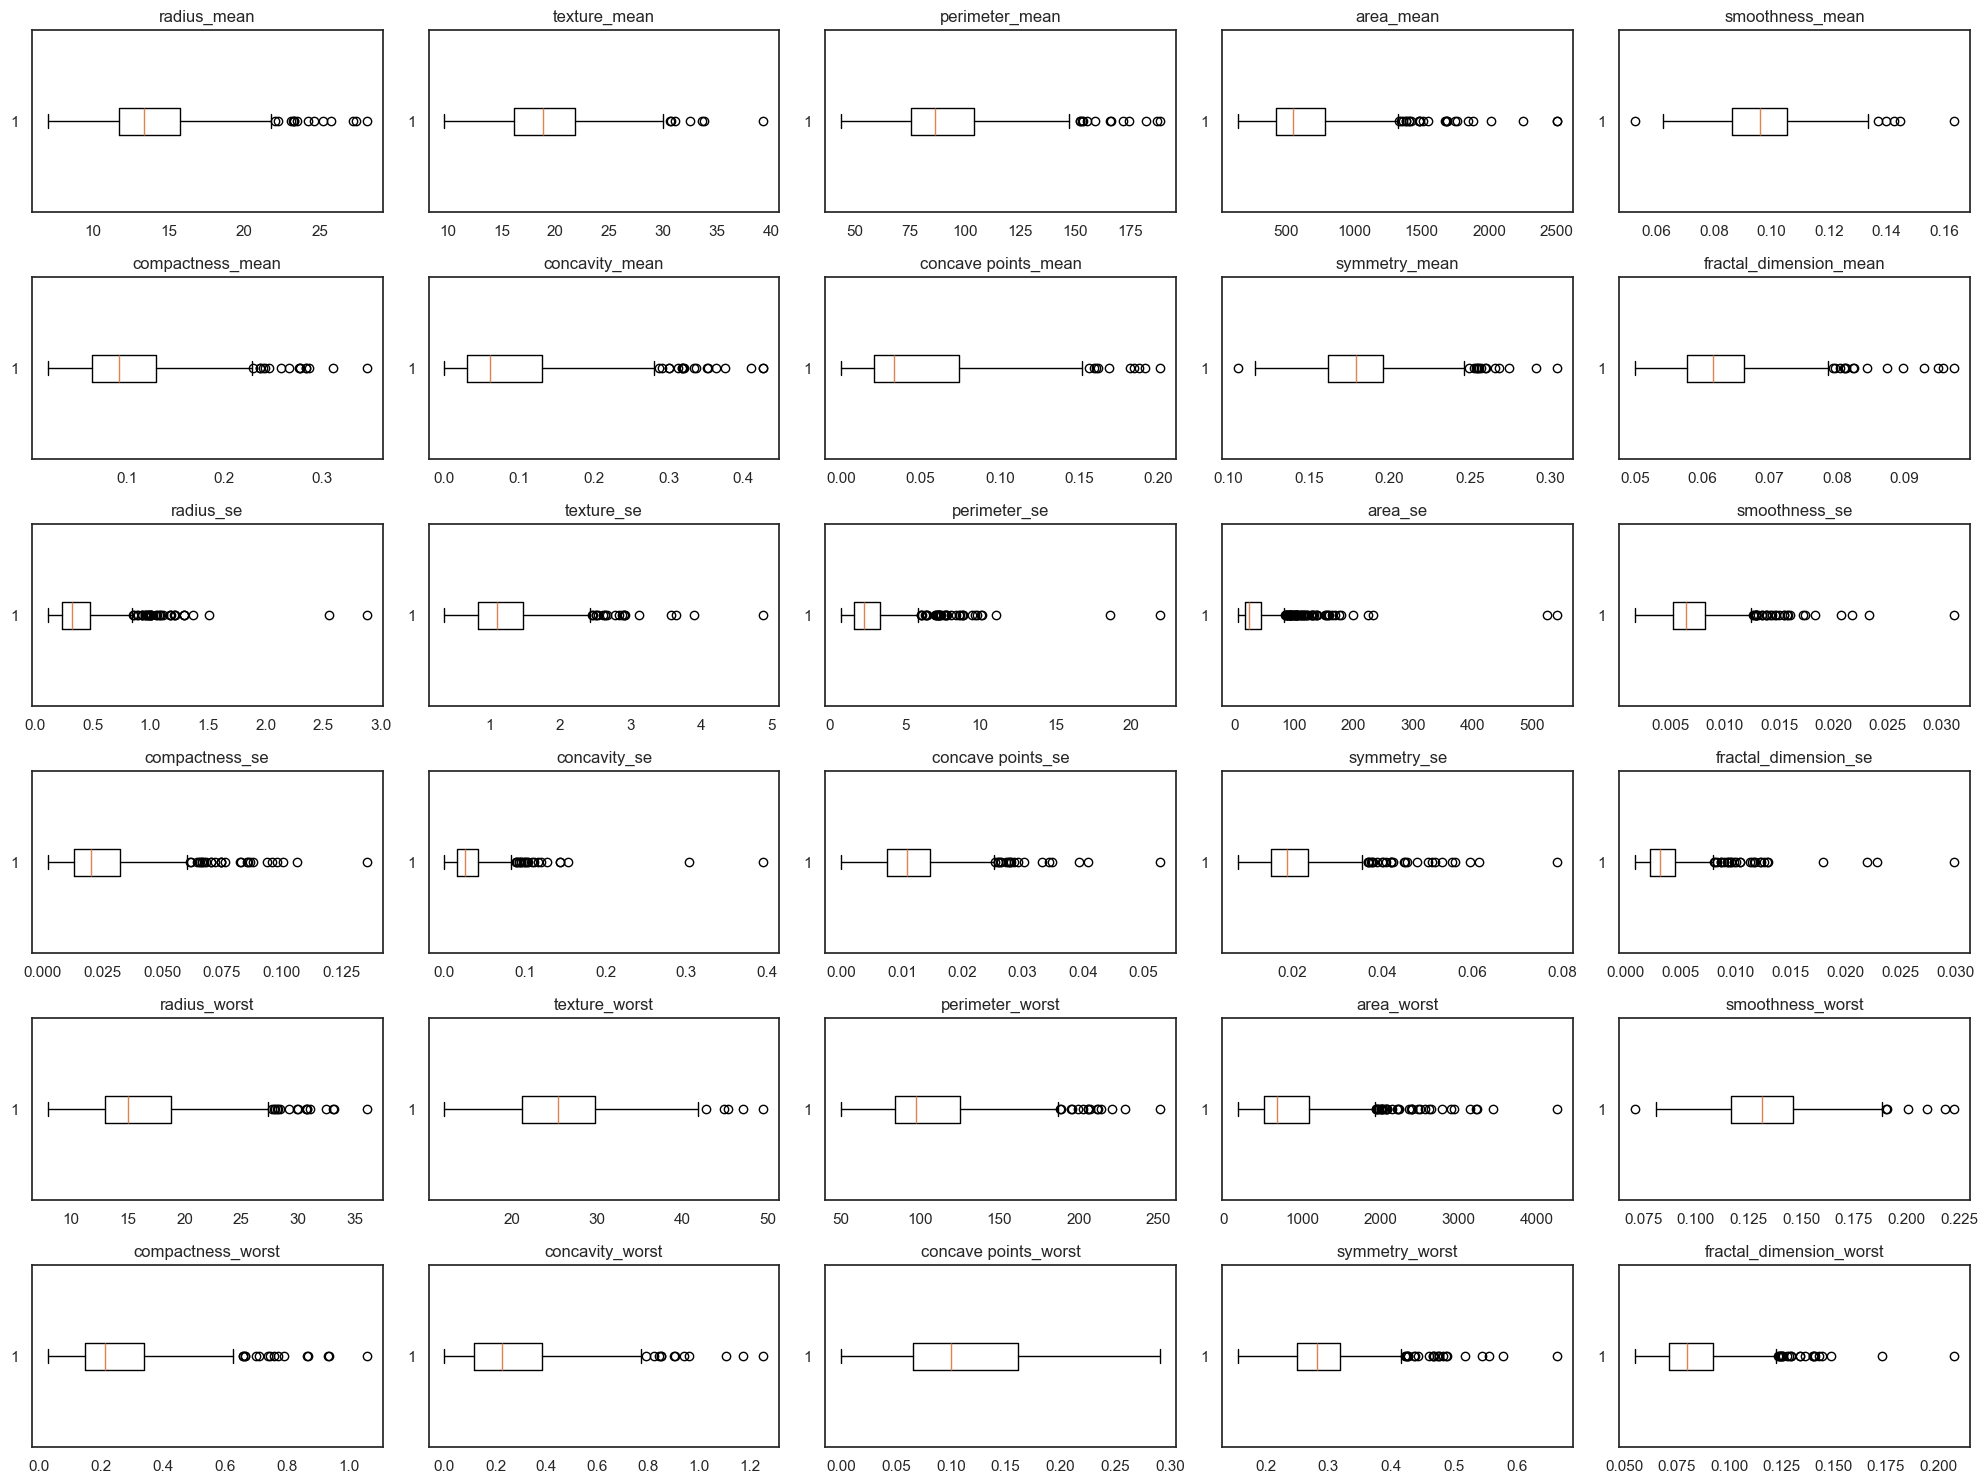

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")  # по умолчанию (без сетки)


plt.figure(figsize=(20, 15))

for i, col in enumerate(df.columns):
    plt.subplot(6, 5, i + 1)
    plt.boxplot(df[col], vert=False)
    plt.title(col)

plt.tight_layout()
plt.show()


На boxplot действительно наблюдается большое количество значений, выходящих за пределы 1.5 IQR. Однако данные выбросы соответствуют реальным биологическим особенностям злокачественных опухолей и отражают клиническую вариативность. Удалять их некорректно, так как это приведёт к потере важной информации и ухудшит качество кластеризации. Вместо удаления выбросов применяется стандартизация признаков, что снижает их влияние на методы, чувствительные к масштабу (например, K-means).

Построим гистограммы распределений:

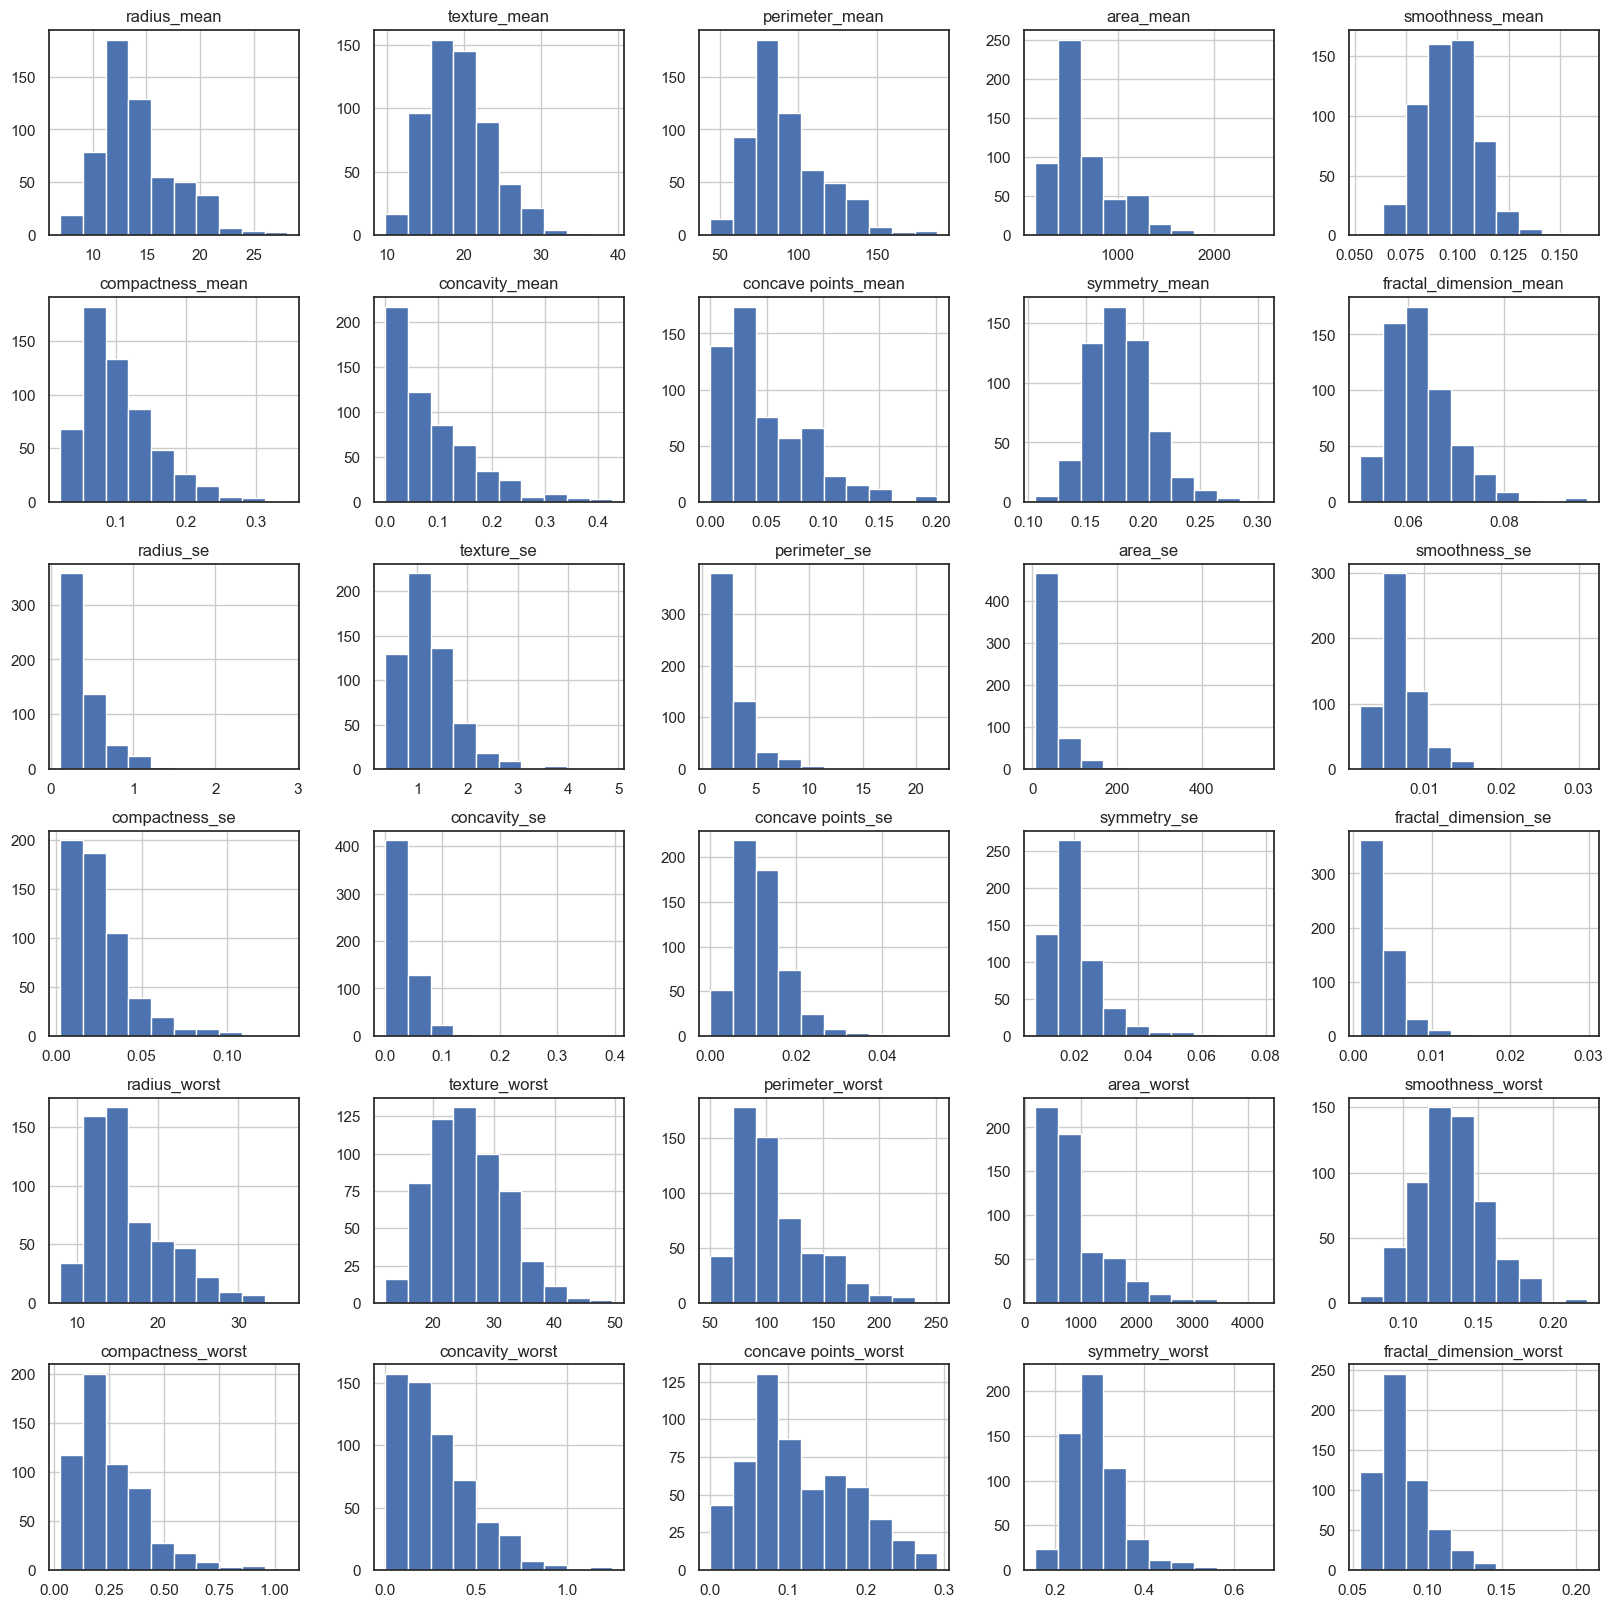

                    feature    W_stat       p_value
0               radius_mean  0.941069  3.105644e-14
1              texture_mean  0.976721  7.283581e-08
2            perimeter_mean  0.936183  7.011402e-15
3                 area_mean  0.858401  3.196264e-22
4           smoothness_mean  0.987487  8.600831e-05
5          compactness_mean  0.916978  3.967204e-17
6            concavity_mean  0.866831  1.338571e-21
7       concave points_mean  0.891650  1.404556e-19
8             symmetry_mean  0.972589  7.884772e-09
9    fractal_dimension_mean  0.923284  1.956575e-16
10                radius_se  0.745554  1.224597e-28
11               texture_se  0.896168  3.560601e-19
12             perimeter_se  0.718164  7.587487e-30
13                  area_se  0.563820  2.652703e-35
14            smoothness_se  0.838410  1.361967e-23
15           compactness_se  0.836878  1.082957e-23
16             concavity_se  0.672070  1.101681e-31
17        concave points_se  0.919706  7.825997e-17
18          

In [92]:

df.hist(bins=10, figsize=(20, 20))
plt.show()

from scipy.stats import shapiro
import pandas as pd

results = []

for col in df.columns:
    W, p = shapiro(df[col])
    results.append({'feature': col, 'W_stat': W, 'p_value': p})

normality_results = pd.DataFrame(results)
print(normality_results)





In [93]:
from sklearn.feature_selection import f_classif
import pandas as pd
y_true = df_orig['diagnosis'].map({'M': 1, 'B': 0}).values
import pandas as pd
from sklearn.feature_selection import f_classif
from scipy.stats import f
# X — матрица признаков, y — классы (0/1)
F_values, p_values = f_classif(df, y_true)

df_anova = pd.DataFrame({
    'feature': df.columns,
    'F_value': F_values,
    'p_value': p_values
}).sort_values("F_value", ascending=False)

# Порог значимости

df1 = 1
df2 = len(df) - 2

alpha = 0.005

F_critical = f.ppf(1 - alpha, df1, df2)
print(f"F-критическое = {F_critical} при уровне значимости {alpha}")
# Отбираем значимые признаки
significant_F = df_anova[df_anova['F_value'] > 400]


print("Значимые признаки:")
print(significant_F)
import seaborn as sns
# список значимых признаков
significant_features = significant_F['feature'].tolist()



F-критическое = 7.941482793717777 при уровне значимости 0.005
Значимые признаки:
                 feature     F_value        p_value
27  concave points_worst  964.385393  1.969100e-124
22       perimeter_worst  897.944219  5.771397e-119
7    concave points_mean  861.676020  7.101150e-116
20          radius_worst  860.781707  8.482292e-116
2         perimeter_mean  697.235272  8.436251e-101
23            area_worst  661.600206   2.828848e-97
0            radius_mean  646.981021   8.465941e-96
3              area_mean  573.060747   4.734564e-88
6         concavity_mean  533.793126   9.966556e-84
26       concavity_worst  436.691939   2.464664e-72


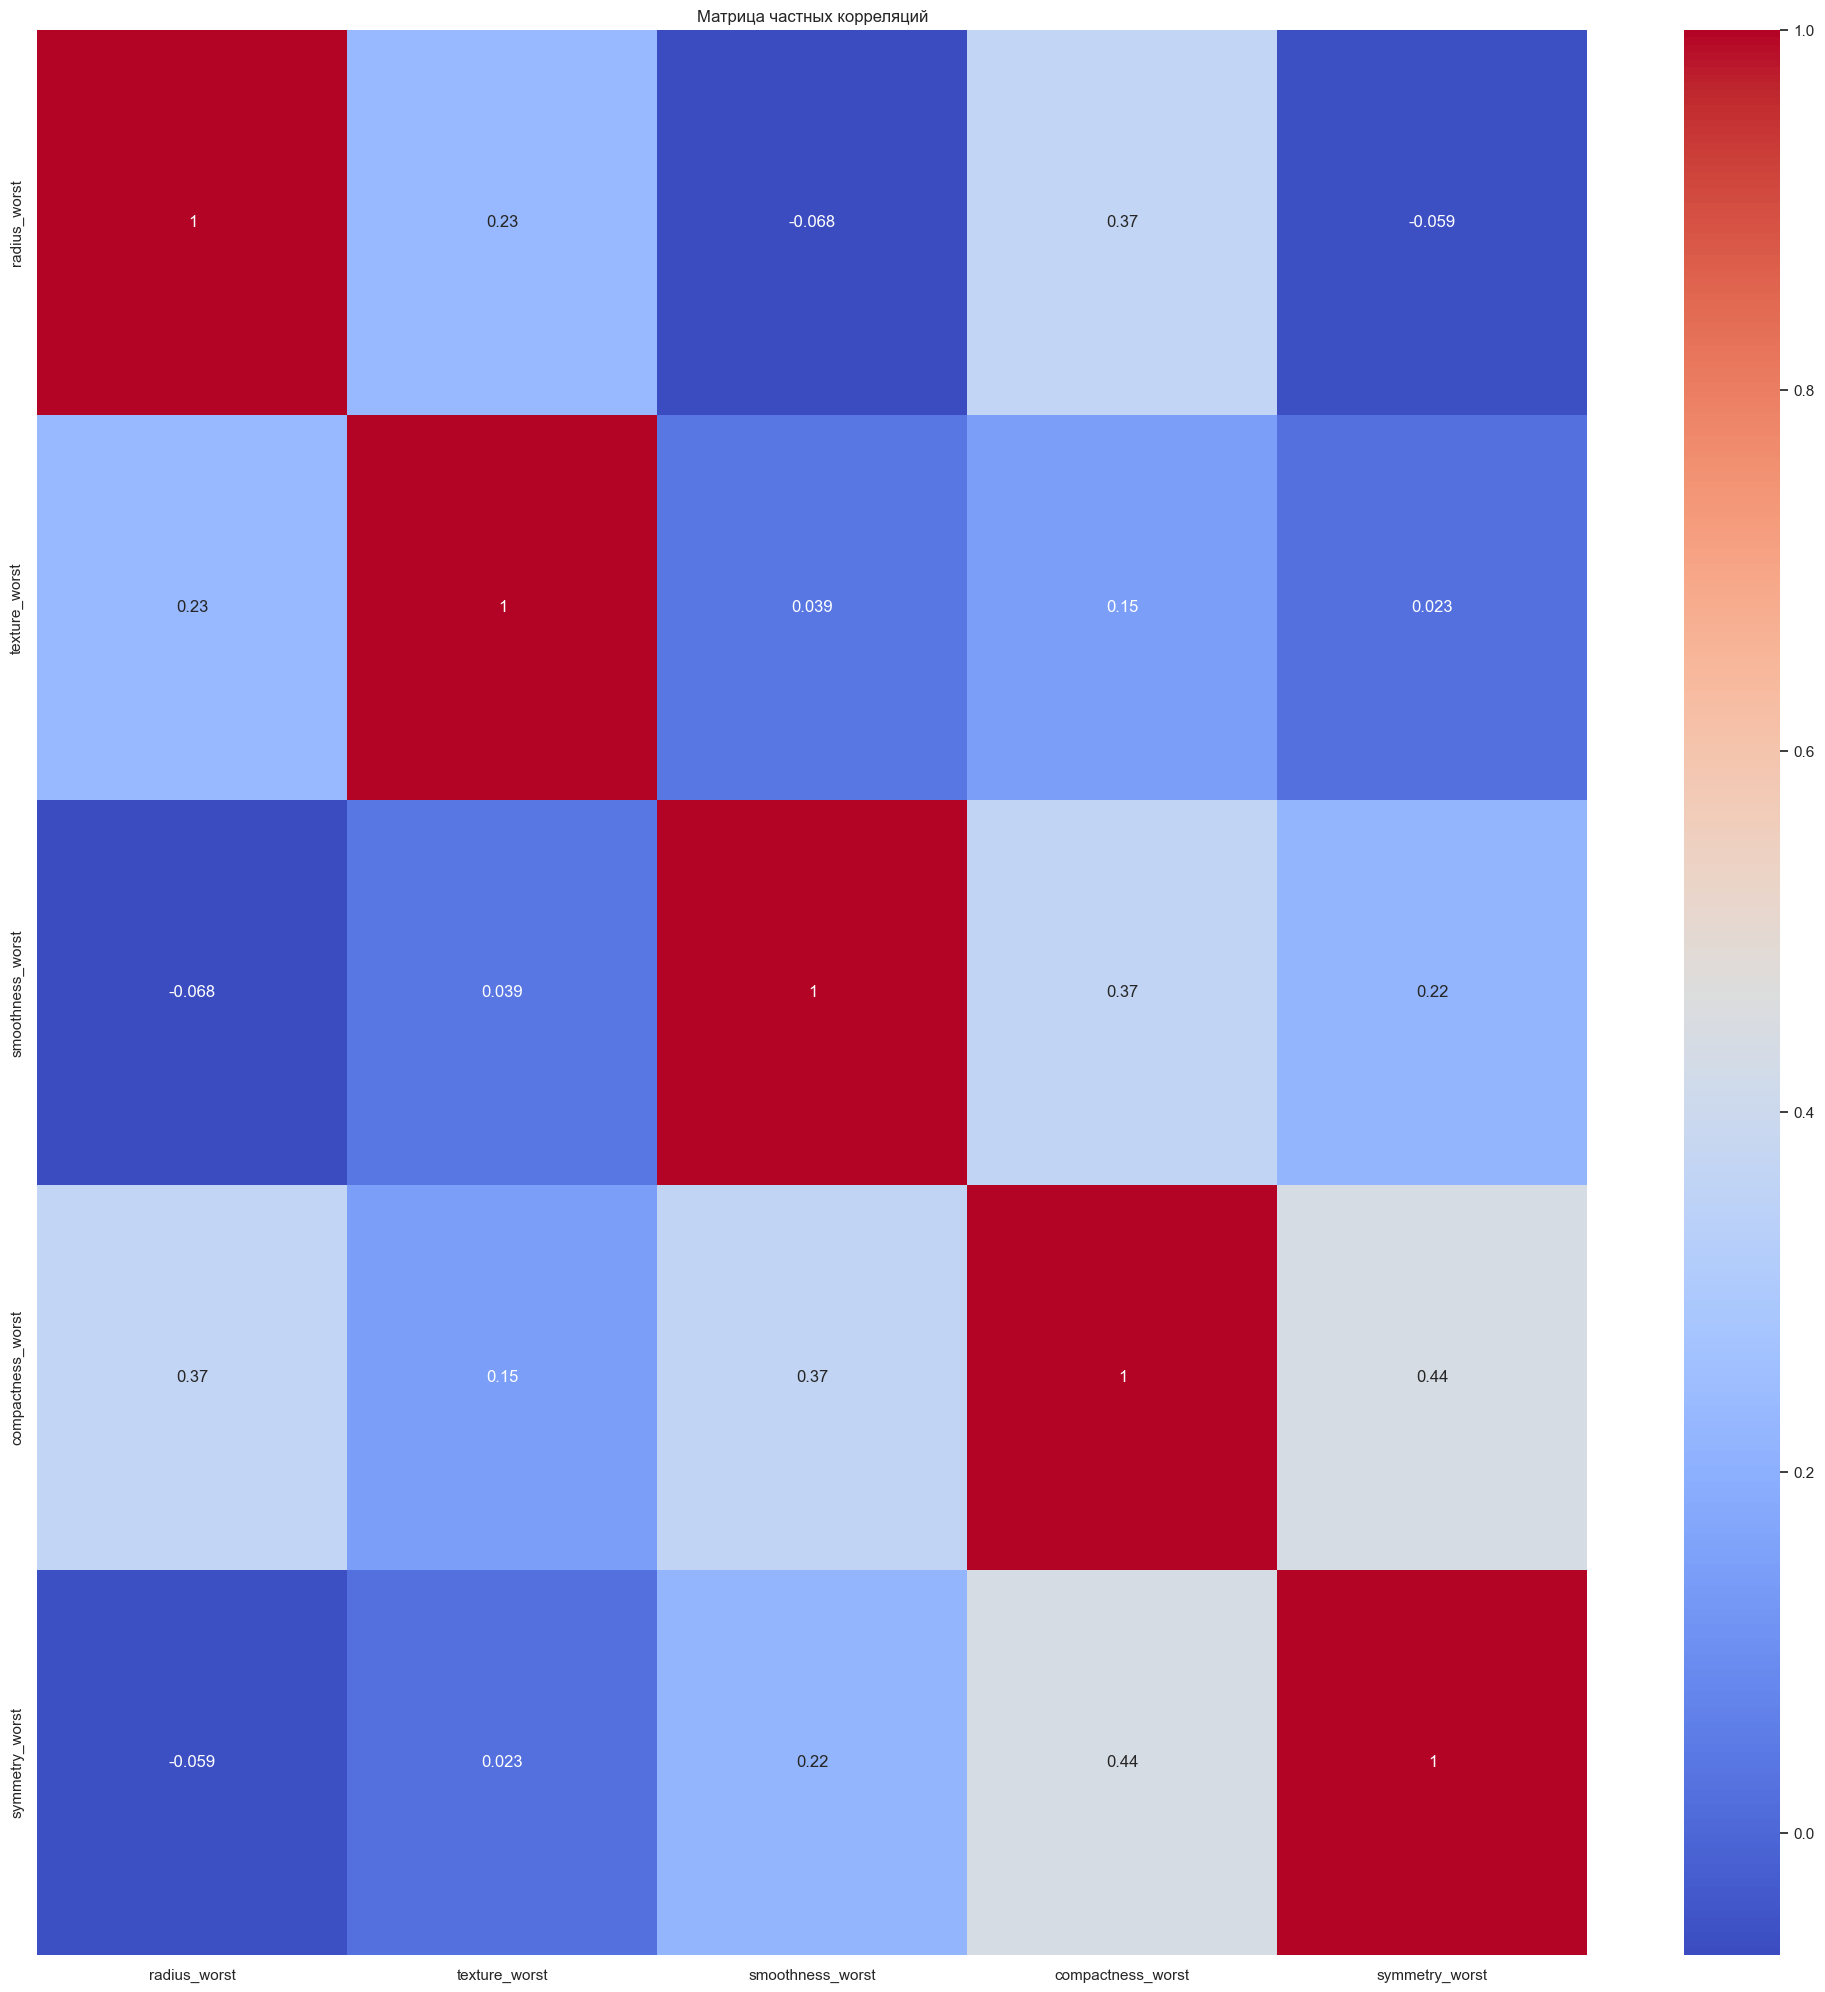

In [94]:
import pandas as pd
import pingouin as pg


features = df.iloc[:, 20:30].drop(columns=['perimeter_worst', 'concave points_worst', 'area_worst', 'concavity_worst', 'fractal_dimension_worst'], axis=1).columns.tolist()
n = len(features)
pcorr_matrix = pd.DataFrame(index=features, columns=features, dtype=float)

for i, x in enumerate(features):
    for j, y in enumerate(features):
        if i == j:
            pcorr_matrix.loc[x, y] = 1.0
        else:
            covar = [c for c in features if c not in [x, y]]
            pcorr_matrix.loc[x, y] = pg.partial_corr(df, x=x, y=y, covar=covar)['r'].values[0]

plt.figure(figsize=(25,25))
sns.heatmap(pcorr_matrix.astype(float), annot=True, cmap='coolwarm')
plt.title('Матрица частных корреляций')
plt.show()


По приведённым гистограммам видно, что большинство признаков в наборе данных Breast Cancer Wisconsin Diagnostic не подчиняются нормальному (гауссовскому) распределению. Распределения значений асимметричны, чаще всего со сдвигом вправо (положительная асимметрия), что означает, что для многих признаков преобладают относительно небольшие значения, а большие встречаются значительно реже.

Показатели, такие как radius_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean, concave_points_mean, демонстрируют экспоненциальный или логнормальный характер распределения, при котором большая часть наблюдений сосредоточена в нижней части диапазона. Это характерно для медицинских данных, где большинство опухолей имеют умеренные характеристики, а экстремальные значения соответствуют злокачественным случаям.

Некоторые признаки, например texture_mean и symmetry_mean, ближе к симметричному распределению, хотя и не являются строго нормальными. Для признаков типа fractal_dimension_mean или smoothness_mean значения распределены в узком диапазоне и также имеют небольшой сдвиг вправо. Таким образом, выборка не соответствует нормальному распределению, что подтверждает необходимость использования методов нормализации или стандартизации данных перед обучением моделей машинного обучения (например, масштабирования с помощью StandardScaler или MinMaxScaler).

## Предобработка данных

Построим матрицу корреляций. В задачах кластеризации наличие сильно коррелирующих переменных приводит к тому, что такие признаки дублируют информацию друг друга и фактически «перетягивают» пространство признаков в одну сторону. Это может искажать расстояния между объектами и ухудшать качество кластеризации, особенно в методах, основанных на евклидовом расстоянии (K-means, иерархическая кластеризация).

Поэтому анализ корреляций необходим для выявления мультиколлинеарности и последующего удаления или объединения признаков, дублирующих друг друга. Это улучшает интерпретируемость и делает пространство признаков более равномерным.

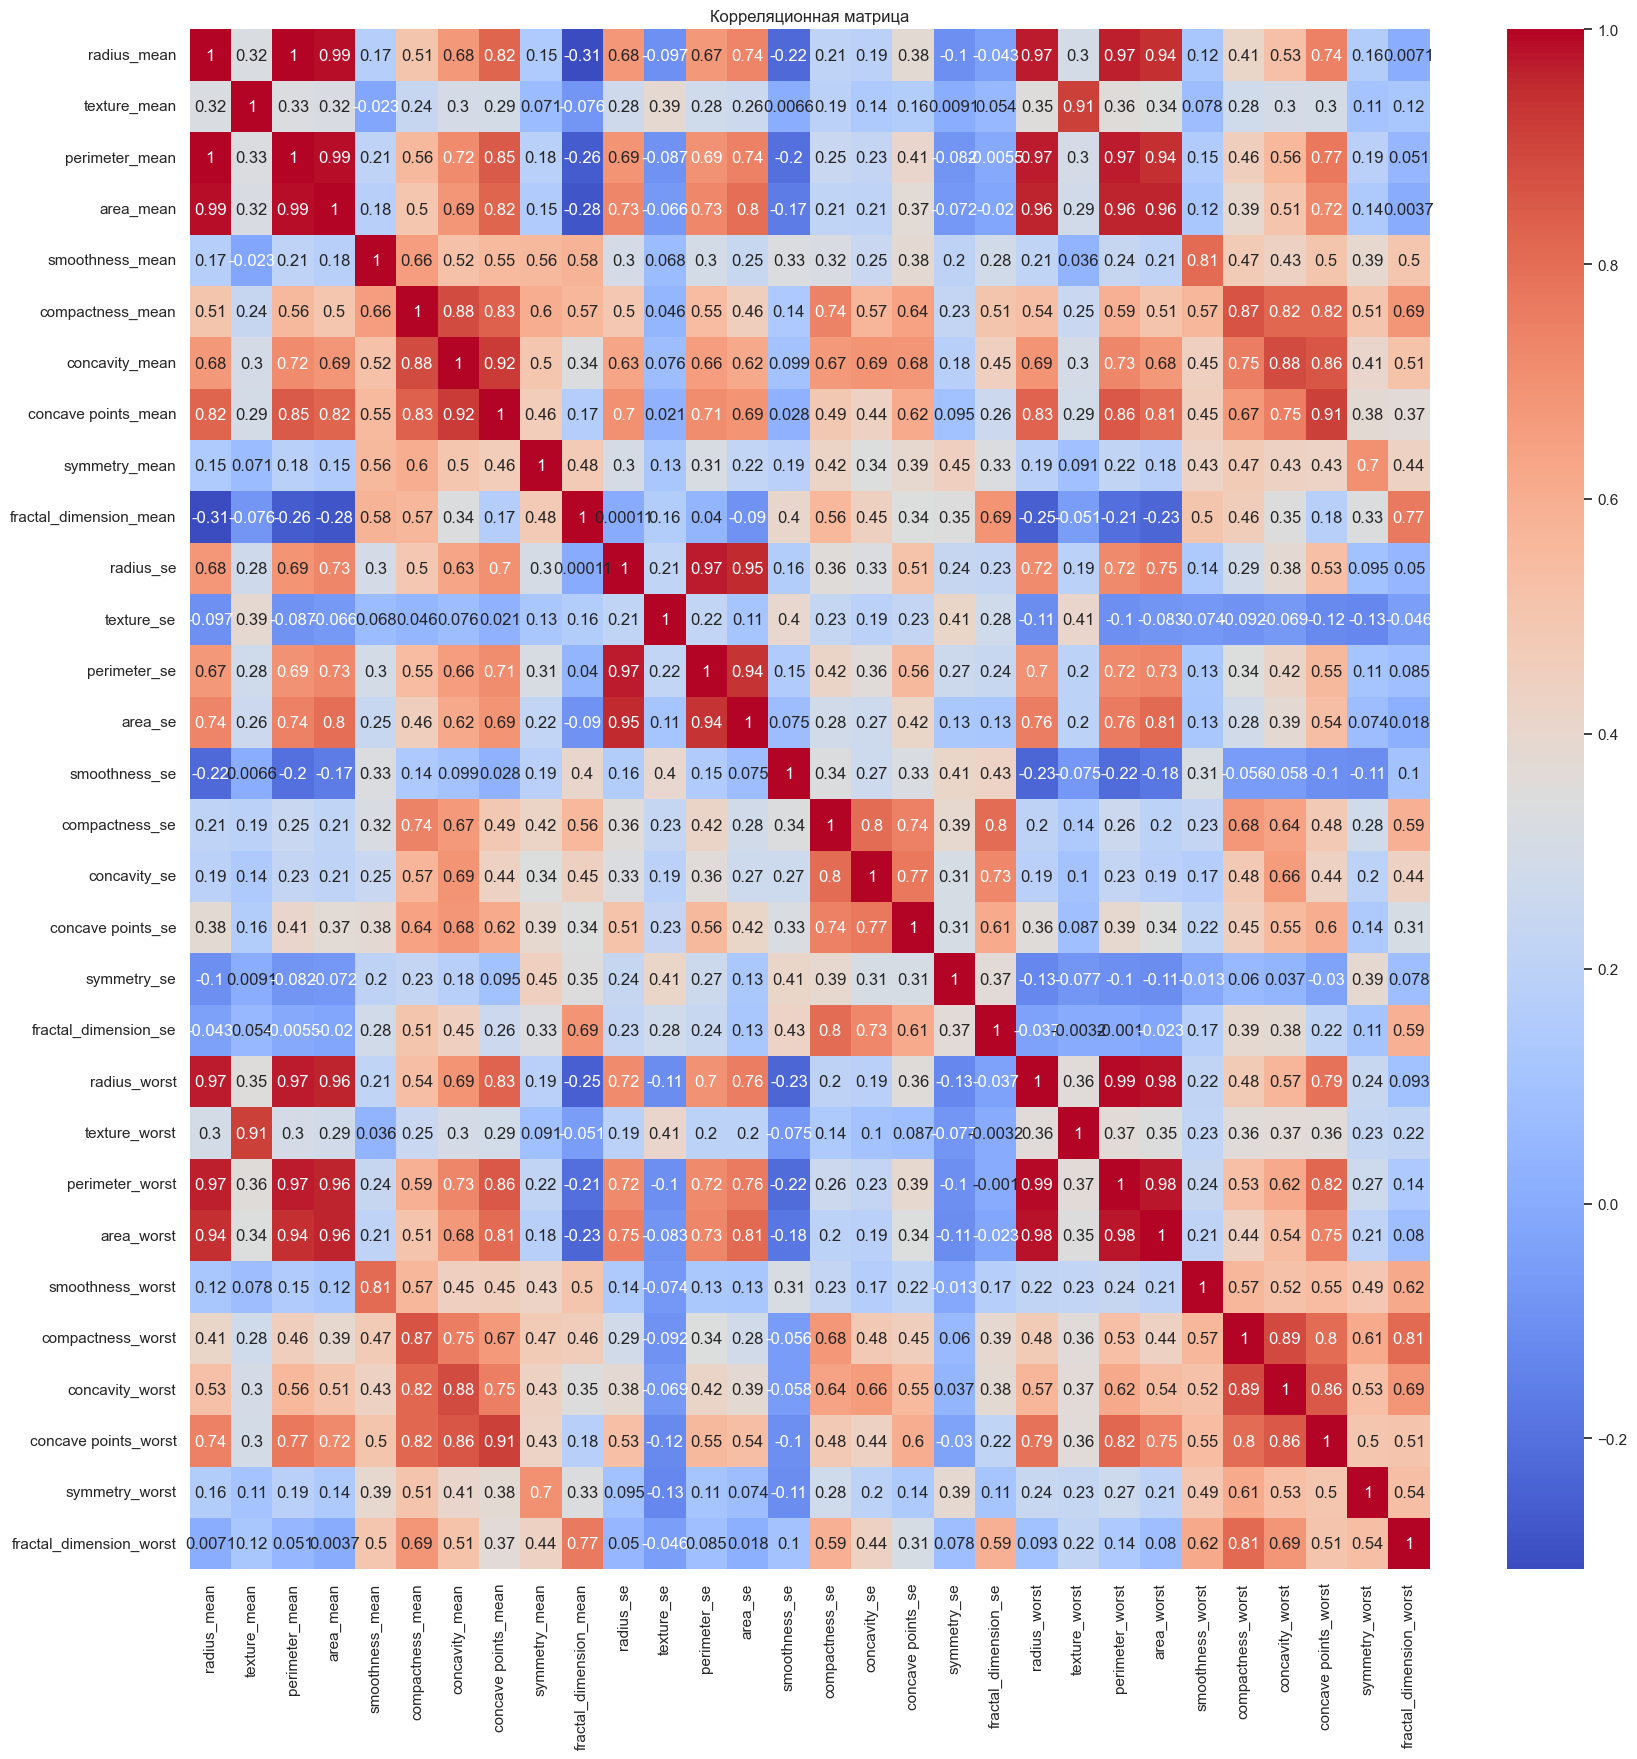

In [95]:
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Согласно матрице корреляций, признаки из трёх групп — _mean, _se и _worst — образуют внутри себя сильные корреляционные блоки.
Например, radius_mean, radius_se и radius_worst имеют корреляции 0.98–0.99; аналогично ведут себя пары perimeter_*, area_*, concavity_*, compactness_*, concave points_* и другие.
Это означает, что внутри каждой группы признаки отражают одно и то же свойство объекта (например, размер опухоли), различаясь лишь масштабом или способом вычисления.

Поскольку три группы признаков (mean, se, worst) сильно коррелируют между собой, присутствие всех трёх групп в модели приводит к избыточности данных.
Для уменьшения размерности признакового пространства и устранения мультиколлинеарности было принято решение оставить только одну наиболее информативную группу — признаки с постфиксом _worst.

Эти признаки часто используются в моделях классификации и кластеризации по breast-cancer dataset, поскольку они отражают наиболее выраженные (наихудшие) характеристики опухолевой ткани, что делает их хорошо различимыми между объектами.

Построим матрицу корреляций только признаков worst:

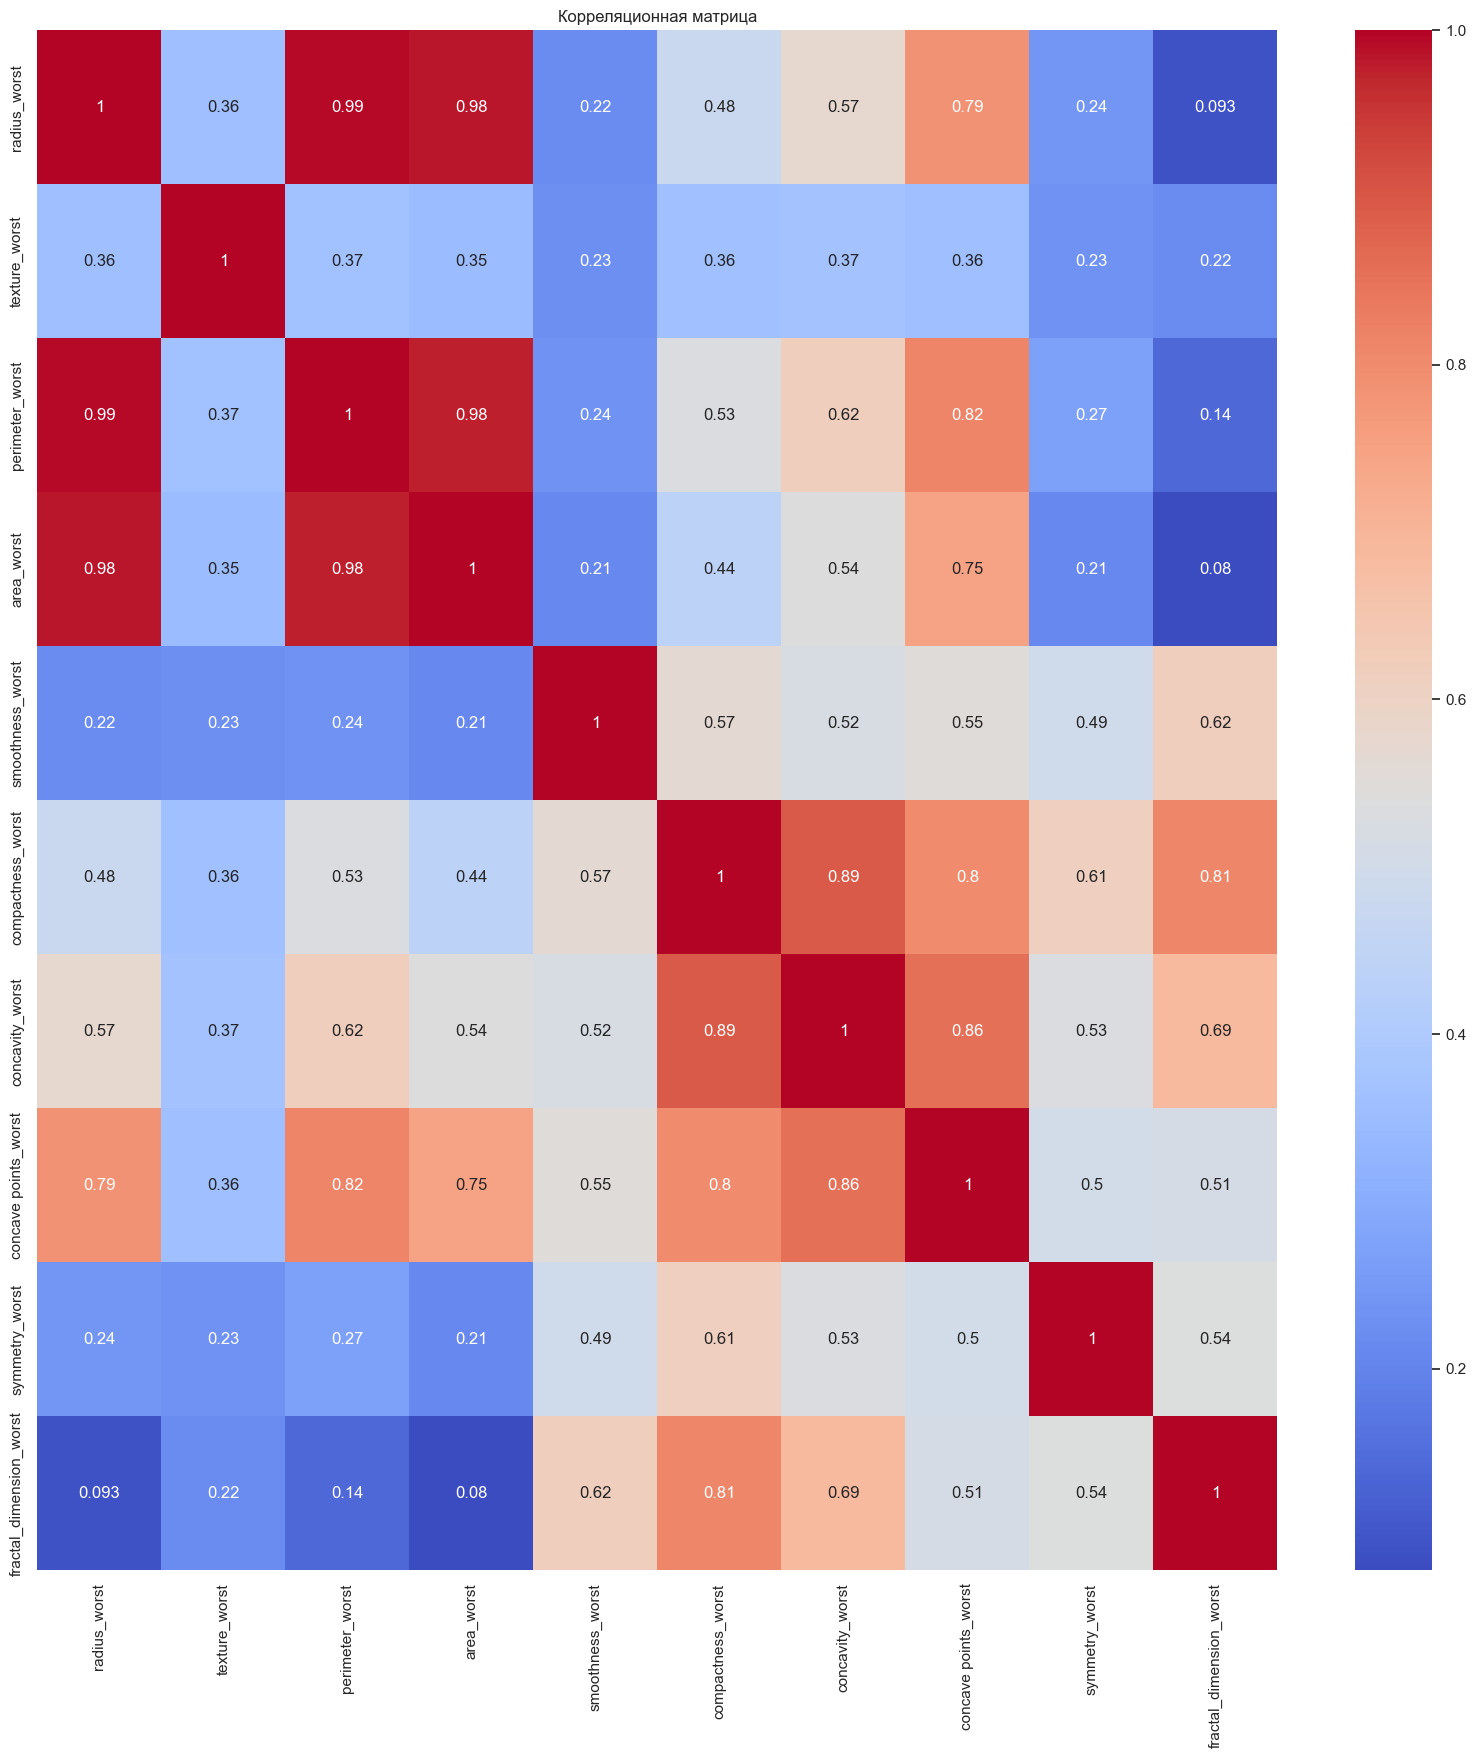

In [96]:
df = df.iloc[:, 20:30]

correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

После того как были оставлены признаки из группы _worst, дополнительная проверка корреляций внутри этой группы показала, что некоторые переменные остаются сильно коррелирующими друг с другом (например, radius_worst, perimeter_worst и area_worst; concavity_worst и concave points_worst, а также compactness_worst и concavity_worst).
Чтобы избежать дублирования информации, из оставшегося набора были удалены следующие признаки:

- perimeter_worst - сильно коррелирует с radius_worst
- area_worst - также практически линейно выражена через radius_worst
- concave points_worst - сильно коррелирует с concavity_worst
- compactness_worst - коррелирует с concavity_worst
- fractal_dimension_worst - наименее изменчивый признак, с небольшой информативностью

Таким образом, в итоговый набор вошли признаки, которые дают наибольший вклад в вариативность данных и не дублируют друг друга.

ПОстроим новую матрицу корреляций и диаграмму рассеивания: 

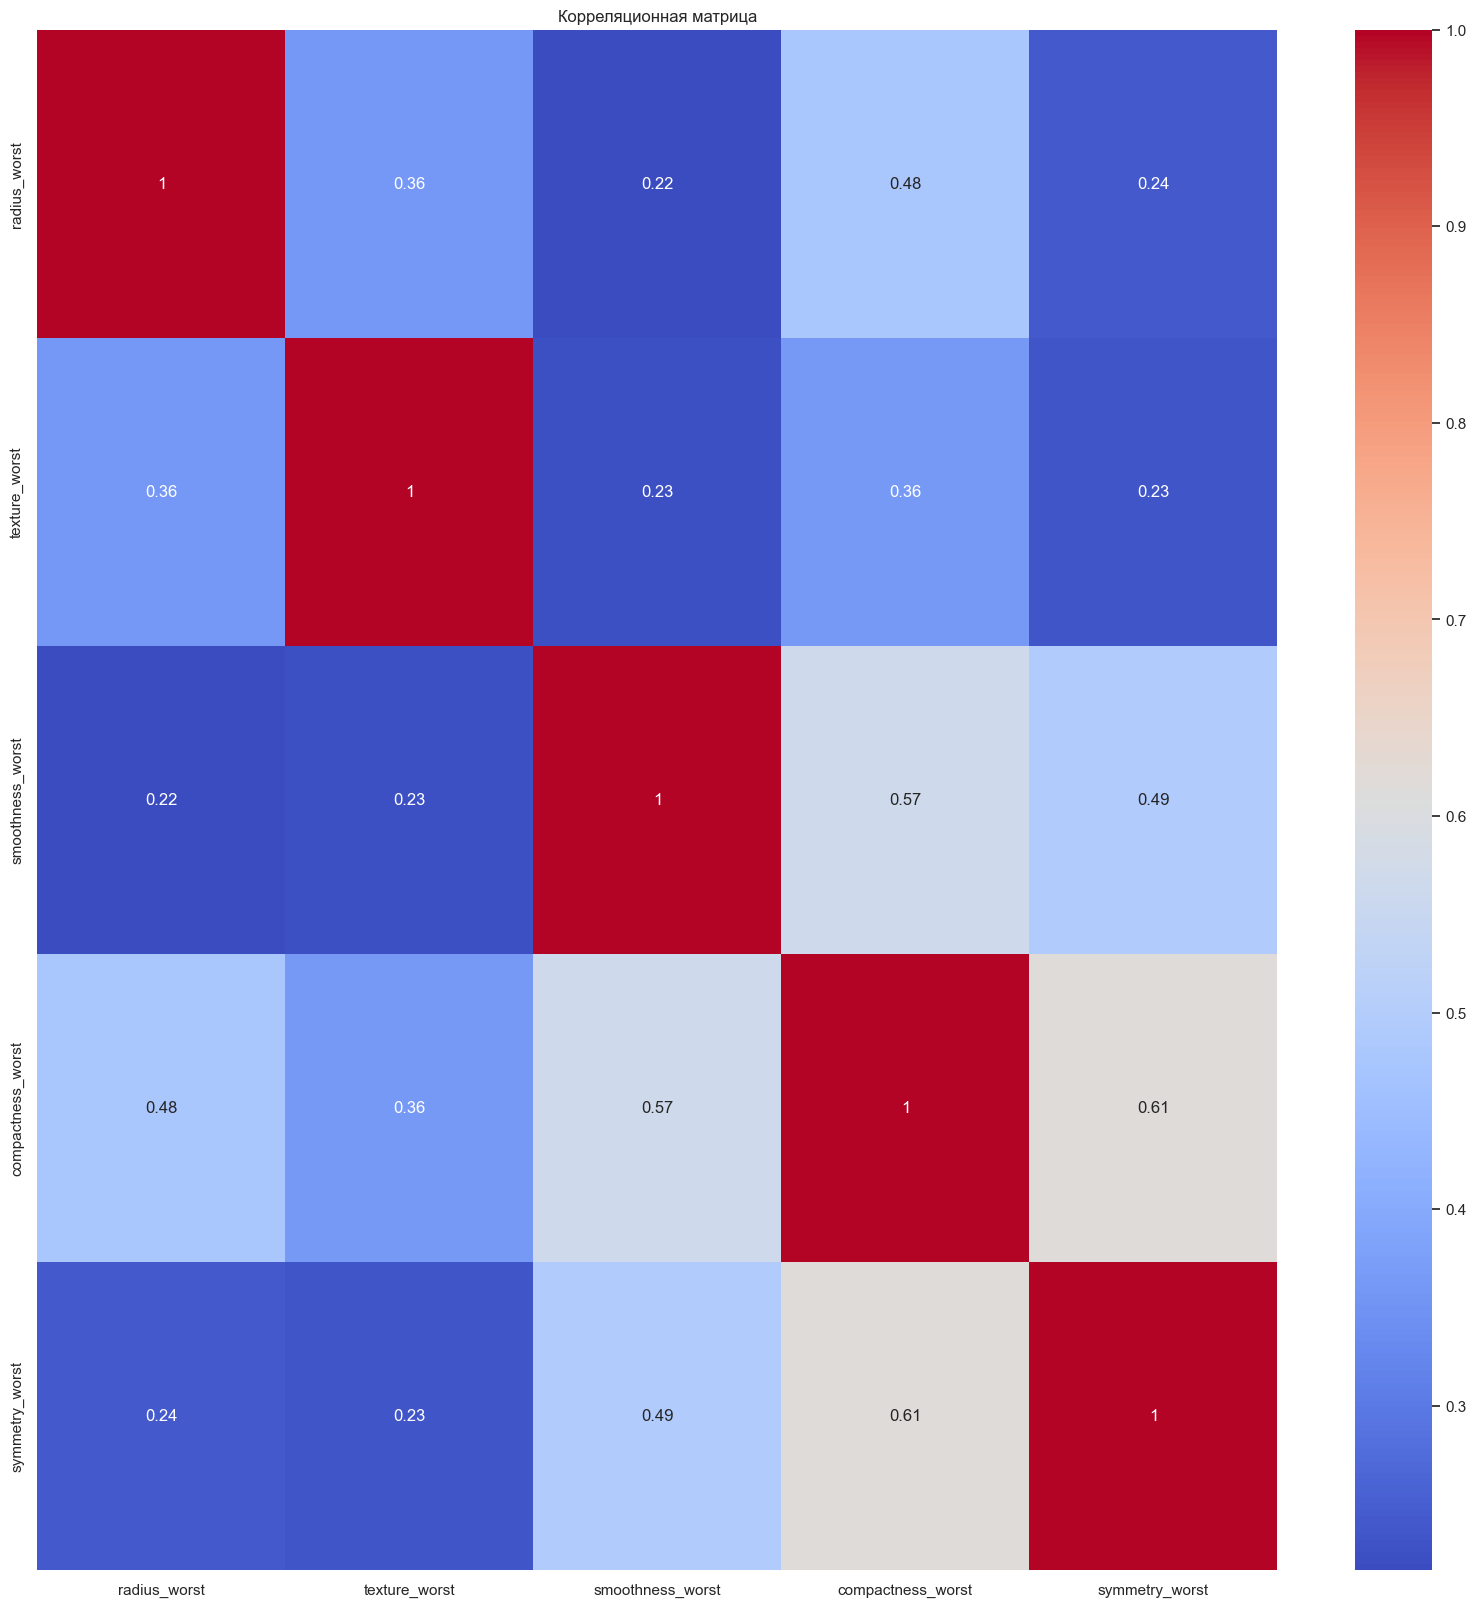

In [97]:
#df = df.drop(columns=['perimeter_mean', 'area_mean', 'concave points_mean', 'compactness_mean', 'smoothness_mean', 'concavity_mean', 'perimeter_se', 'area_se', 'concave points_se', 'compactness_se', 'smoothness_se', 'concavity_se', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst', 'compactness_worst', 'smoothness_worst', 'concavity_worst', 'texture_worst'], axis=1)
df = df.drop(columns=['perimeter_worst', 'concave points_worst', 'area_worst', 'concavity_worst', 'fractal_dimension_worst'], axis=1)

correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()


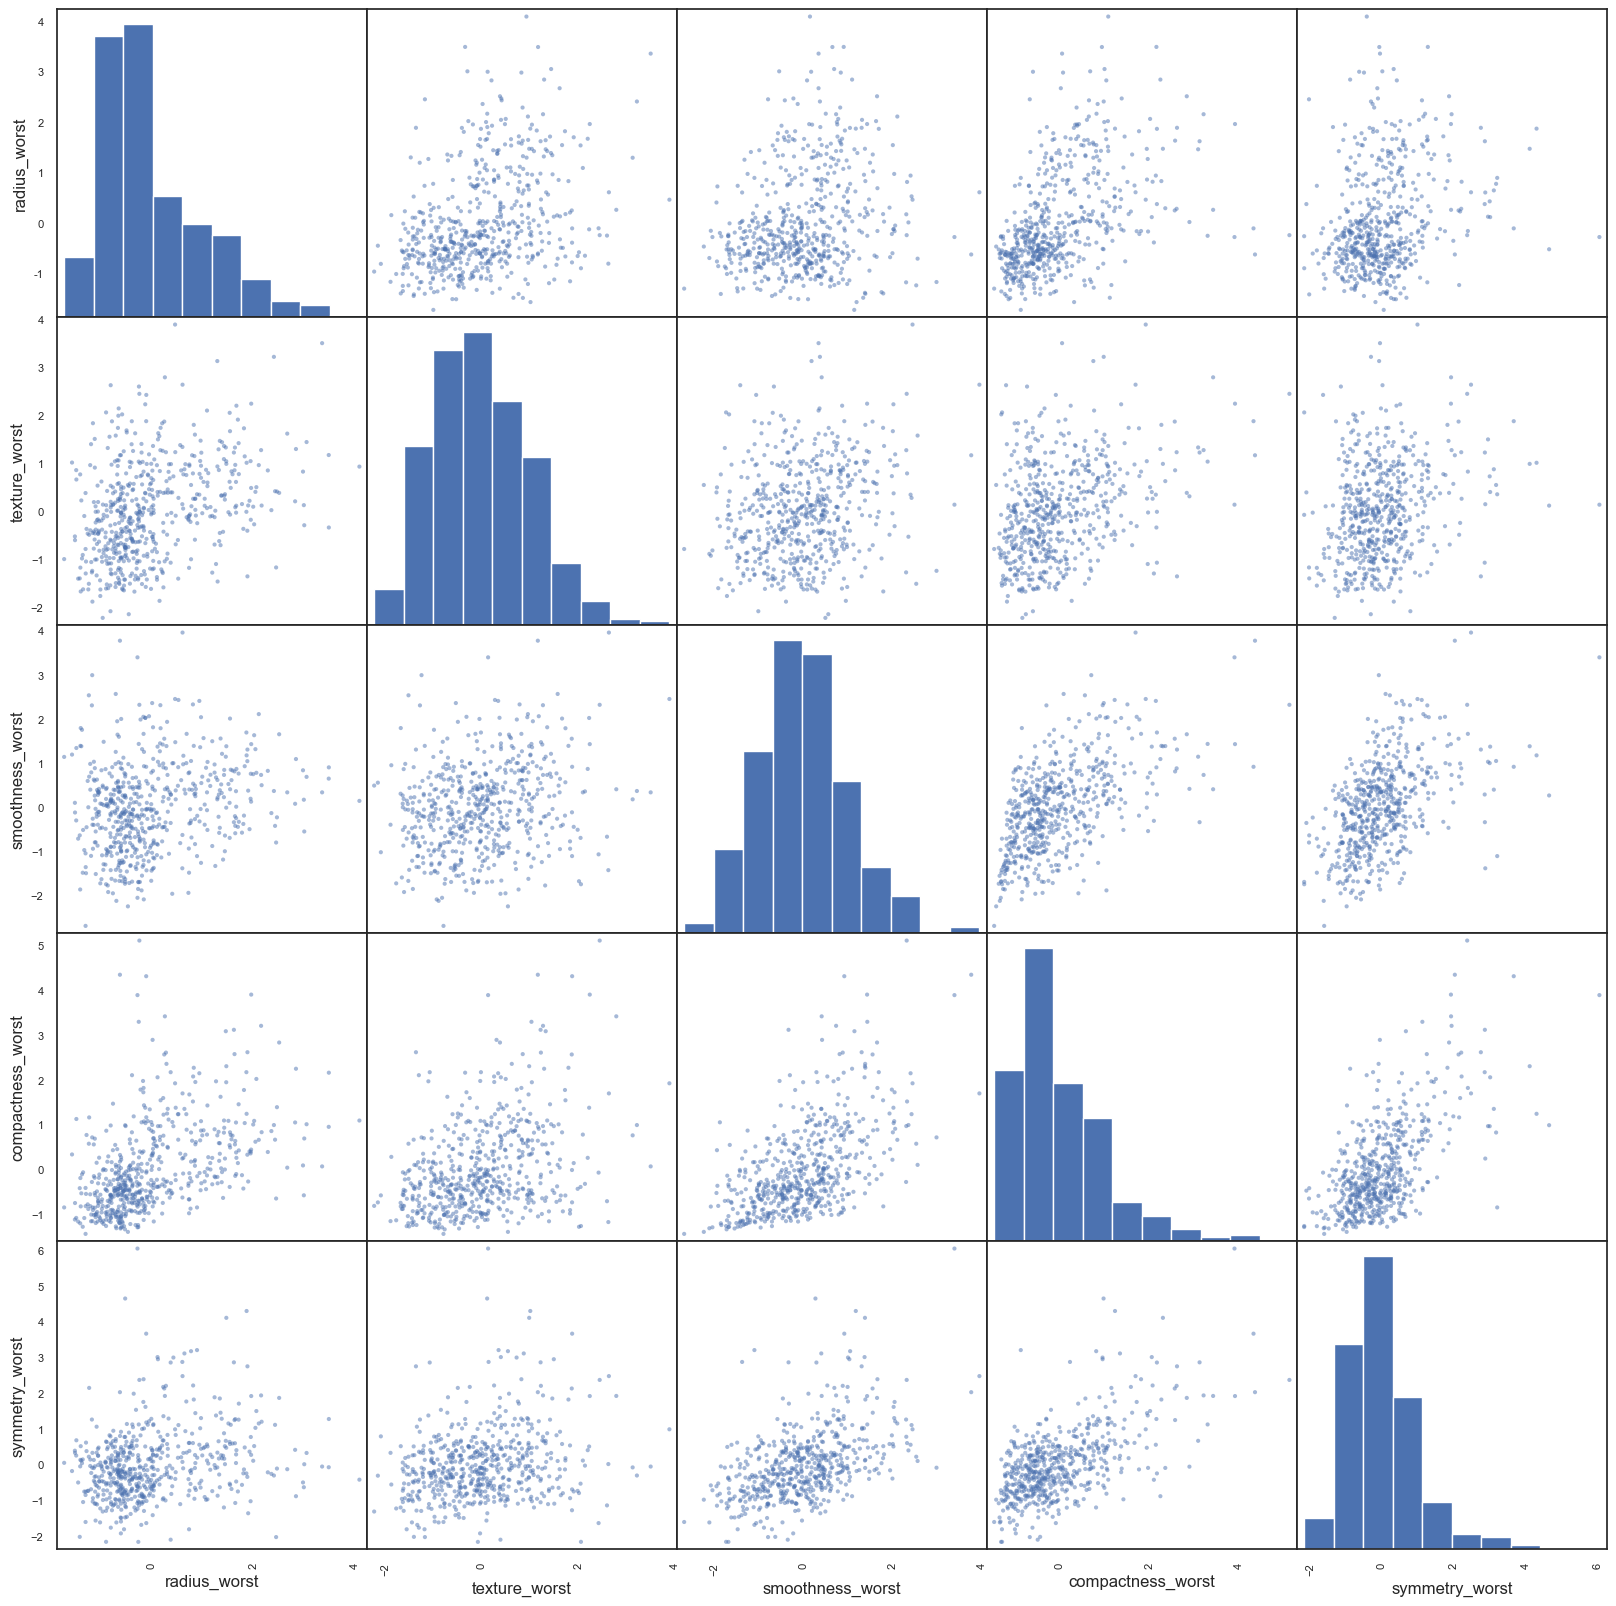

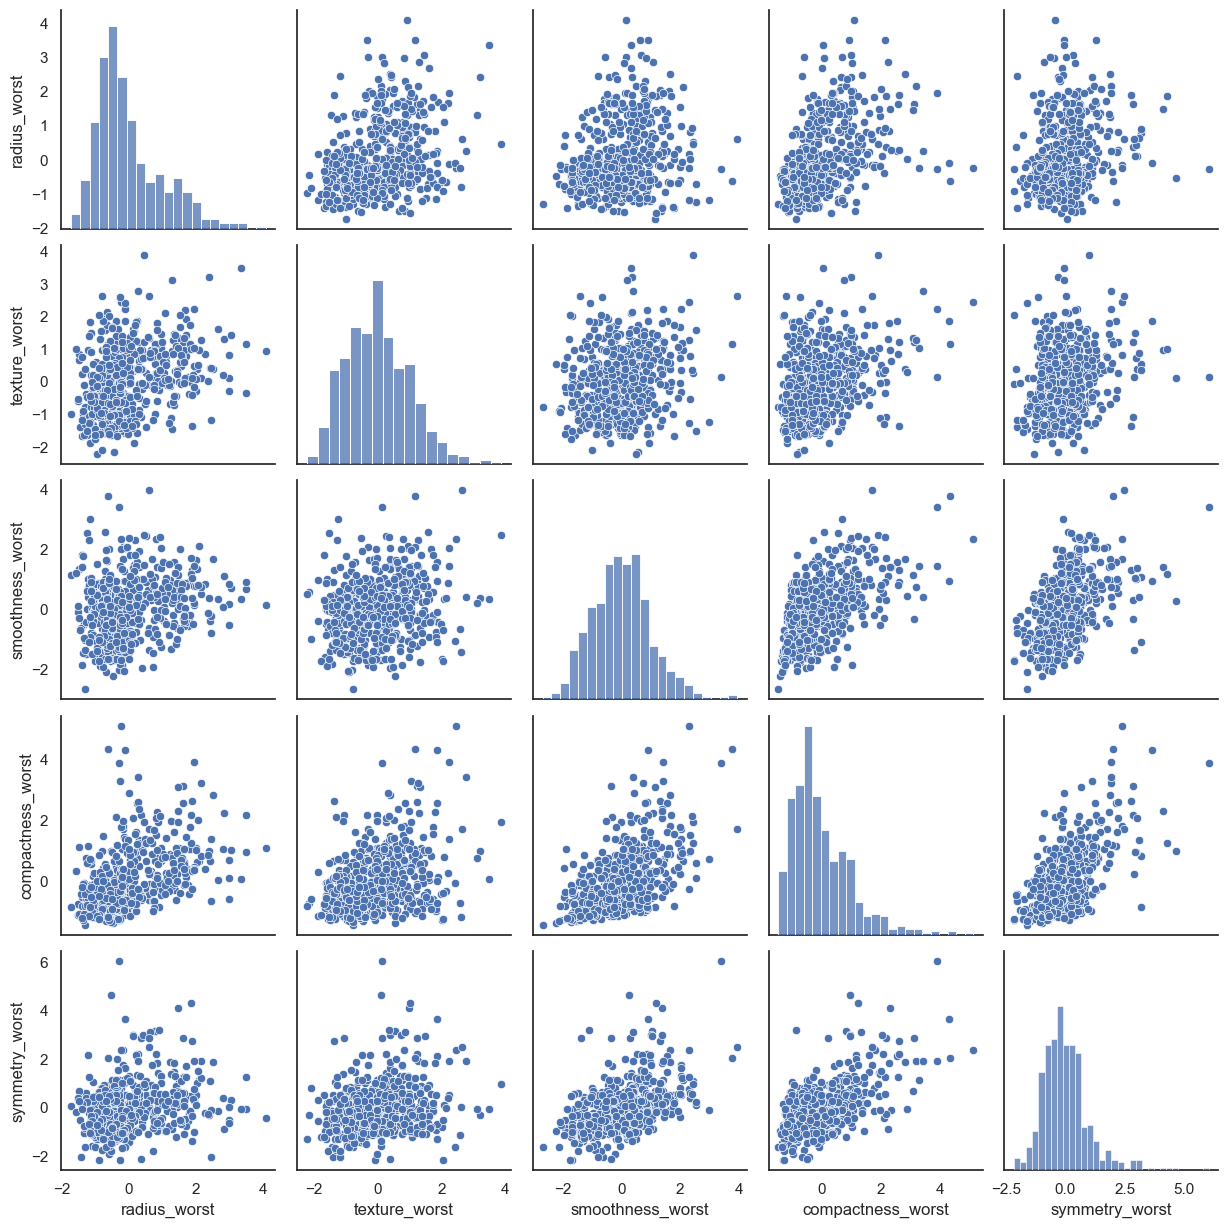

In [98]:
from sklearn.preprocessing import StandardScaler

X = df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

pd.plotting.scatter_matrix(df_scaled, figsize=(20, 20))
sns.pairplot(df_scaled)


Построенная матрица диаграмм рассеивания позволяет провести предварительную визуальную оценку структуры данных и понять, насколько выражены потенциальные кластеры. На графиках видно, что объекты распределены довольно равномерно, без чётко обособленных «островков» плотности, что говорит об отсутствии явно разделённых групп. Вместе с тем в некоторых парах признаков, например между radius_worst и concavity_worst, а также между radius_worst и smoothness_worst, прослеживаются умеренные линейные тенденции, указывающие на возможное формирование вытянутых, а не сферических кластеров. Подобная форма распределения предполагает, что границы между потенциальными группами размыты, кластеры могут пересекаться, а их плотность меняется постепенно, без резких скачков. Это также подтверждает, что данные не обладают выраженными разреженными областями, которые позволили бы однозначно разделить их на кластеры визуально.

Такое распределение влияет на выбор методов кластеризации: использование K-means остаётся возможным благодаря стандартизации признаков и отсутствию критических выбросов, однако стоит учитывать, что алгоритм предполагает сферическую форму кластеров и может работать не идеально при вытянутой структуре данных. В отличие от него, иерархическая кластеризация более оправдана для данной задачи, так как она не предполагает конкретной формы кластеров и позволяет выявлять вложенную структуру данных на разных уровнях объединения объектов. Этот метод хорошо справляется с постепенным изменением плотности и позволяет визуально оценить разбиение данных через дендрограмму, что особенно полезно при работе с пересекающимися и частично размытыми кластерами. DBSCAN в данном случае не является оптимальным выбором, так как распределение точек скорее плавное и непрерывное, без плотных компактных групп, необходимых для устойчивой работы данного метода.

Таким образом, визуальная оценка диаграммы рассеивания показывает слабовыраженную, частично перекрывающуюся кластерную структуру, что делает применение иерархической кластеризации более оправданным, наряду с K-means, для получения интерпретируемого и наглядного разбиения данных.

Стандартизируем данные:

Данные успешно стандартизированы и обработаны, можно переходить к следующим шагам.

## Ход работы

### Определение количества кластеров

Сначала определим количество кластером с помощью метода локтя и графика силуэтного анализа для K-means:

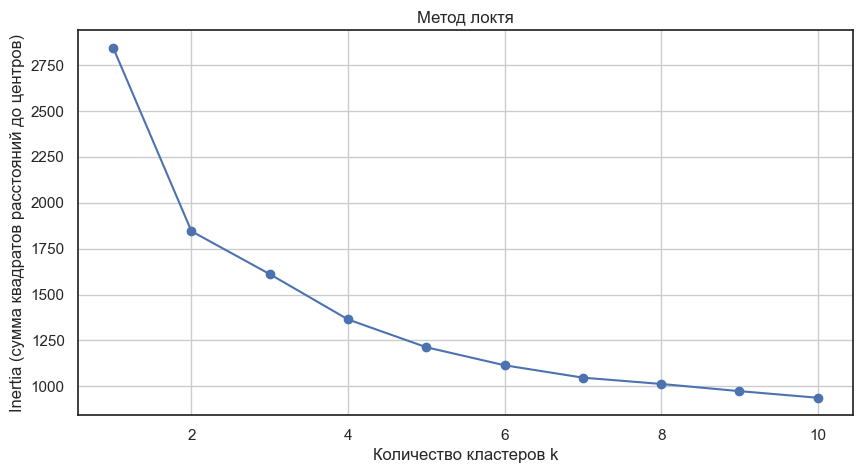

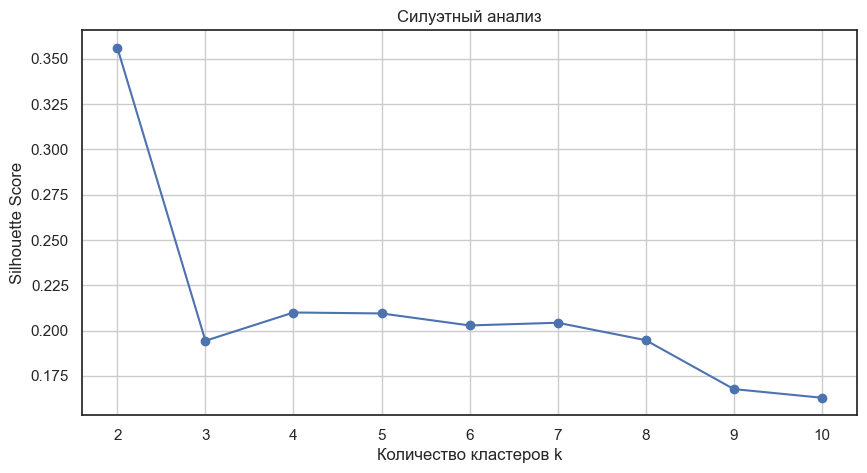

In [99]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K_range, inertia, marker='o')
plt.title("Метод локтя")
plt.xlabel("Количество кластеров k")
plt.ylabel("Inertia (сумма квадратов расстояний до центров)")
plt.grid(True)
plt.show()
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

plt.figure(figsize=(10,5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Силуэтный анализ")
plt.xlabel("Количество кластеров k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


На графике локтя отчётливо видно, что при переходе от 1 кластера к 2 происходит резкое снижение значения inertia, что свидетельствует о существенном улучшении качества разбиения.
После k = 2 темп уменьшения становится значительно меньше, а дальнейшее увеличение числа кластеров (3, 4, 5...) приводит лишь к плавному и незначительному снижению суммарного квадратичного отклонения.

Это означает, что точка перегиба (локоть) формируется в районе k = 2, что типично для ситуаций, когда данные естественно распределены примерно в две группы.

По графику силуэтного анализа Значение silhouette score достигает максимума при k = 2 — примерно 0.35.
Это означает следующее: 
- Кластеры при k = 2 наиболее плотные.
- Кластеры хорошо отделены друг от друга.

При увеличении k качество разбиения ухудшается: silhouette score падает до 0.23 при k = 3 и продолжает снижаться далее.

Максимум метрики — основной критерий выбора оптимального k, поэтому силуэтный метод также указывает на k = 2.

Теперь построим дендрограмму:

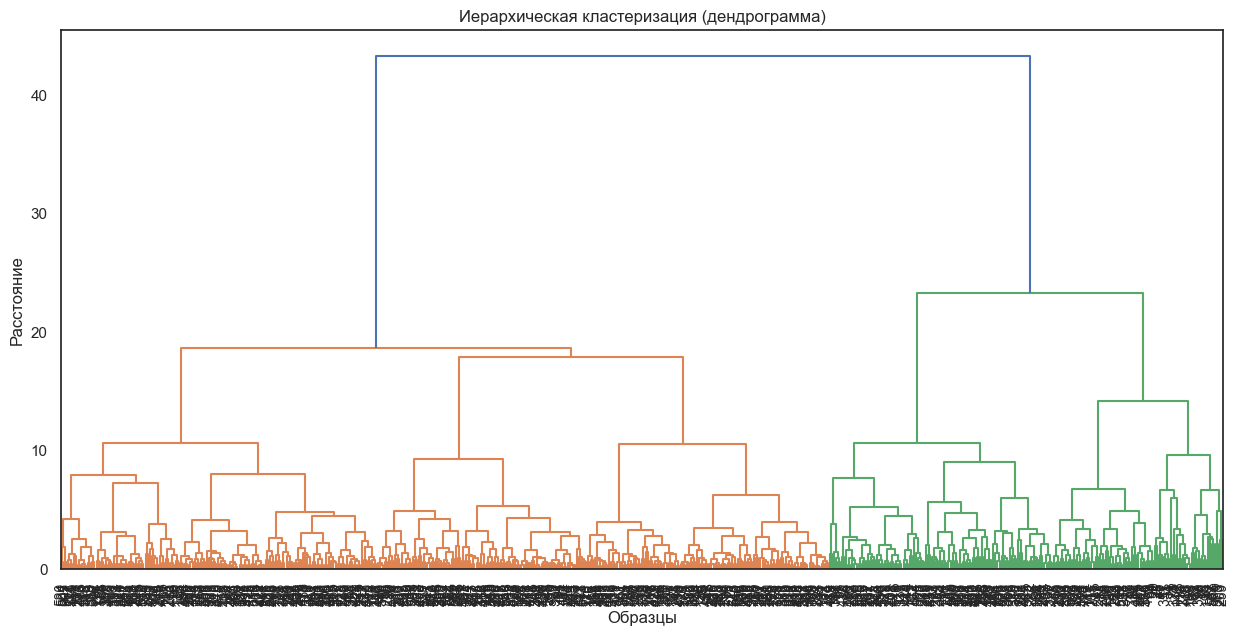

In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

# linkage — строим иерархию
Z = linkage(df_scaled, method='ward')  # метод Ward минимизирует внутрикластерную дисперсию

# рисуем дендрограмму
plt.figure(figsize=(15, 7))
dendrogram(Z, leaf_rotation=90, leaf_font_size=10)
plt.title('Иерархическая кластеризация (дендрограмма)')
plt.xlabel('Образцы')
plt.ylabel('Расстояние')
plt.show()

На графике видно два очень высоких столба, которые соединяются примерно на уровне 45. Это означает, что до этой высоты дендрограмма держится разделённой на две крупные ветви. Ниже уровня около 18–20 каждая из этих двух ветвей распадается на более мелкие группы, но эти разрывы заметно меньше.

Таким образом, оптимальное количество кластеров по дендрограмме — два, потому что самый крупный разрыв наблюдается именно при объединении в два кластера.

Если требуется выбрать более детальное разбиение и учитывать разрывы средних размеров, можно было бы выделять три кластера, но исходя из классического правила «максимального вертикального разрыва», корректнее остановиться именно на двух.

### Построение моделей

In [101]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmn = kmeans.fit_predict(df_scaled)

labels_hier = fcluster(Z, 2, criterion='maxclust')

In [102]:
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import rand_score, fowlkes_mallows_score,  jaccard_score
from scipy.spatial.distance import cdist
import pandas as pd

y_true = df_orig['diagnosis'].map({'M': 1, 'B': 0}).values

def cluster_analysis(X, labels):
    n_clusters = len(np.unique(labels))
    
    # Внутренние метрики
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    
    # Внешние метрики
    ri = rand_score(y_true, labels)
    f = fowlkes_mallows_score(y_true, labels)
    
    # Кластеры
    cluster_centers = []
    intra_dists = []
    for c in np.unique(labels):
        cluster_points = X[labels == c]
        center = cluster_points.mean(axis=0)
        cluster_centers.append(center)
        dists = cdist(cluster_points, [center])
        intra_dists.append(dists.mean())

    
    mean_intra = np.mean(intra_dists)
    
    if n_clusters > 1:
        pairwise_centers = cdist(cluster_centers, cluster_centers)
        mean_inter = pairwise_centers[np.triu_indices(n_clusters, k=1)].mean()
    else:
        mean_inter = 0
    
    compactness = np.sum(intra_dists)
    
    outliers = 0
    for c in np.unique(labels):
        cluster_points = X[labels == c]
        center = cluster_points.mean(axis=0)
        dists = cdist(cluster_points, [center]).flatten()
        threshold = dists.mean() + 2*dists.std()
        outliers += np.sum(dists > threshold)
    
    return {
        "Silhouette": sil,
        "Calinski-Harabasz": ch,
        "Davies-Bouldin": db,
        "Rand Index": ri,
        "Fowlkes-Mallows": f,
        "Среднее внутрикластерное расстояние": mean_intra,
        "Среднее межкластерное расстояние": mean_inter,
        "Компактность": compactness,
        "Выбросы": outliers
    }

# Анализ для K-means
kmn_metrics = cluster_analysis(df_scaled, labels_kmn)

# Анализ для иерархической кластеризации
hier_metrics = cluster_analysis(X_scaled, labels_hier)

# Внутренние метрики
internal_df = pd.DataFrame({
    "Метод": ["K-means", "Иерархическая"],
    "Silhouette": [kmn_metrics["Silhouette"], hier_metrics["Silhouette"]],
    "Calinski-Harabasz": [kmn_metrics["Calinski-Harabasz"], hier_metrics["Calinski-Harabasz"]],
    "Davies-Bouldin": [kmn_metrics["Davies-Bouldin"], hier_metrics["Davies-Bouldin"]],
})

# Внешние метрики
external_df = pd.DataFrame({
    "Метод": ["K-means", "Иерархическая"],
    "Rand Index": [kmn_metrics["Rand Index"], hier_metrics["Rand Index"]],
    "Fowlkes-Mallows": [kmn_metrics["Fowlkes-Mallows"], hier_metrics["Fowlkes-Mallows"]],
})

# Характеристики кластеров
cluster_props_df = pd.DataFrame({
    "Метод": ["K-means", "Иерархическая"],
    "Ср внутрикл расст": [kmn_metrics["Среднее внутрикластерное расстояние"], hier_metrics["Среднее внутрикластерное расстояние"]],
    "Ср межкласт расст": [kmn_metrics["Среднее межкластерное расстояние"], hier_metrics["Среднее межкластерное расстояние"]],
    "Компактность": [kmn_metrics["Компактность"], hier_metrics["Компактность"]],
    "Выбросы": [kmn_metrics["Выбросы"], hier_metrics["Выбросы"]],
})

print("Внутренние метрики:")
print(internal_df.round(3))
print("\nВнешние метрики:")
print(external_df.round(3))
print(jaccard_score(y_true, labels_hier, average='macro'))
print(jaccard_score(y_true, labels_kmn, average='micro'))
print("\nХарактеристики кластеров:")
print(cluster_props_df)


Внутренние метрики:
           Метод  Silhouette  Calinski-Harabasz  Davies-Bouldin
0        K-means       0.356            307.361           1.222
1  Иерархическая       0.331            279.052           1.294

Внешние метрики:
           Метод  Rand Index  Fowlkes-Mallows
0        K-means       0.814            0.832
1  Иерархическая       0.891            0.899
0.015421115065243178
0.8121019108280255

Характеристики кластеров:
           Метод  Ср внутрикл расст  Ср межкласт расст  Компактность  Выбросы
0        K-means           1.749813           2.863825      3.499625       19
1  Иерархическая           1.754687           2.712495      3.509375       22


Сравнительный анализ показывает, что оба метода кластеризации, K-means и иерархическая, демонстрируют достаточно высокое качество разбиения данных, однако наблюдаются различия в деталях. По внутренним метрикам K-means имеет несколько более высокий показатель Silhouette и Calinski-Harabasz, что указывает на более плотное и компактное распределение объектов внутри кластеров и на лучшее разделение между ними с точки зрения структуры данных. Davies-Bouldin для K-means немного ниже, что также подтверждает более высокую компактность и меньшую схожесть соседних кластеров по сравнению с иерархической кластеризацией.

С точки зрения внешних метрик, иерархическая кластеризация показывает более высокие значения Rand Index и Fowlkes-Mallows, что свидетельствует о лучшем совпадении кластеров с истинными метками классов. Это указывает на то, что иерархический метод способен более корректно отражать реальную структуру данных, даже если внутренние показатели плотности кластеров немного ниже, чем у K-means.

Анализ характеристик кластеров показывает, что среднее внутрикластерное расстояние у обоих методов практически одинаково, а среднее межкластерное расстояние немного больше у K-means, что соответствует его более компактным кластерам. Компактность кластеров и количество выбросов также близки между методами, хотя K-means демонстрирует чуть меньше выбросов. В целом, результаты позволяют сделать вывод, что K-means обеспечивает более плотные и хорошо разделённые кластеры, тогда как иерархическая кластеризация лучше воспроизводит истинную структуру классов, что делает оба метода взаимодополняющими при анализе данного набора данных.

### Влияение параметров

Исследуем влияние количества кластеров на метод K-средних:

   k  Silhouette  Calinski-Harabasz  Davies-Bouldin  Rand Index  \
0  2       0.356            307.365           1.217       0.814   
1  3       0.293            222.753           1.397       0.838   
2  4       0.209            204.516           1.504       0.683   
3  5       0.210            189.831           1.355       0.623   
4  6       0.209            175.679           1.402       0.614   
5  7       0.204            160.901           1.420       0.606   

   Fowlkes-Mallows  
0            0.832  
1            0.840  
2            0.640  
3            0.547  
4            0.529  
5            0.513  


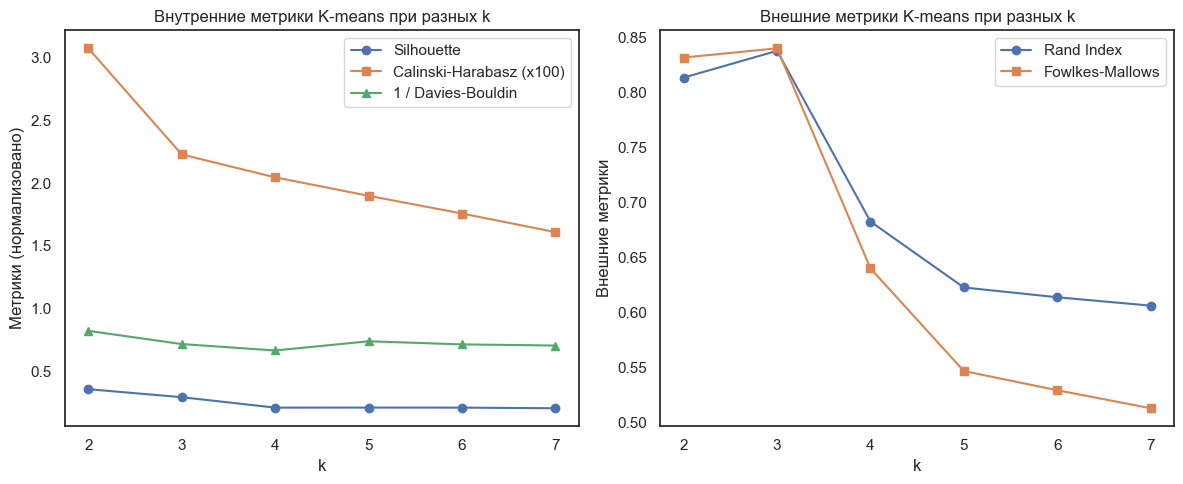

In [103]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import rand_score, fowlkes_mallows_score

k_values = range(2, 8)  
results = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    
    ri = rand_score(y_true, labels)
    fm = fowlkes_mallows_score(y_true, labels)
    
    results.append({
        "k": k,
        "Silhouette": sil,
        "Calinski-Harabasz": ch,
        "Davies-Bouldin": db,
        "Rand Index": ri,
        "Fowlkes-Mallows": fm
    })

df_results = pd.DataFrame(results)
print(df_results.round(3))


import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(df_results["k"], df_results["Silhouette"], marker='o', label='Silhouette')
plt.plot(df_results["k"], df_results["Calinski-Harabasz"]/100, marker='s', label='Calinski-Harabasz (x100)')
plt.plot(df_results["k"], 1/df_results["Davies-Bouldin"], marker='^', label='1 / Davies-Bouldin')
plt.xlabel('k')
plt.ylabel('Метрики (нормализовано)')
plt.title('Внутренние метрики K-means при разных k')
plt.legend()

plt.subplot(1,2,2)
plt.plot(df_results["k"], df_results["Rand Index"], marker='o', label='Rand Index')
plt.plot(df_results["k"], df_results["Fowlkes-Mallows"], marker='s', label='Fowlkes-Mallows')
plt.xlabel('k')
plt.ylabel('Внешние метрики')
plt.title('Внешние метрики K-means при разных k')
plt.legend()

plt.tight_layout()
plt.show()


Судя по таблице, влияние числа кластеров на K-means видно достаточно наглядно. При k=2
внутренние метрики показывают наибольшие значения: Silhouette равен 0.36, Calinski-Harabasz 318.5, а Davies-Bouldin — наименьший, 1.196. Это говорит о том, что кластеры при двух группах наиболее компактные и хорошо разделённые. Внешние метрики при k=2 тоже высоки: Rand Index 0.825 и Fowlkes-Mallows 0.842, что соответствует хорошему совпадению с истинными метками.

При увеличении числа кластеров до 3 наблюдается небольшое снижение Silhouette до 0.294 и Calinski-Harabasz до 222.9, а Davies-Bouldin растёт до 1.45, что указывает на более разреженные и менее чётко разделённые кластеры. Однако Rand Index и Fowlkes-Mallows слегка увеличиваются до 0.854 и 0.856 соответственно, что говорит о частичной подстройке кластеров к реальным классам.

Дальнейшее увеличение числа кластеров до 4–7 приводит к значительному падению Silhouette и Calinski-Harabasz, росту Davies-Bouldin и снижению внешних метрик. Это означает, что кластеры становятся слишком маленькими и менее информативными, появляется избыточное разбиение, и результаты теряют интерпретируемость.

Таким образом, оптимальное число кластеров для данного набора данных методом K-means — 2, так как оно обеспечивает наилучшее сочетание плотности, разделения кластеров и соответствия реальным классам.

## Визуализация результатов

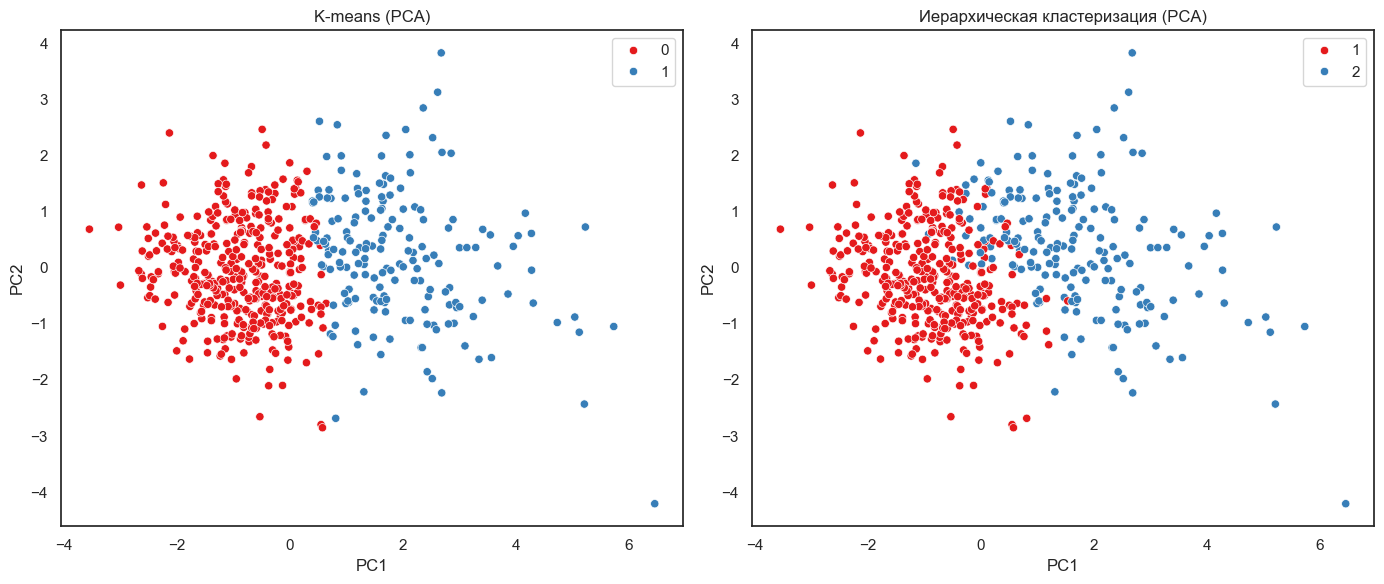

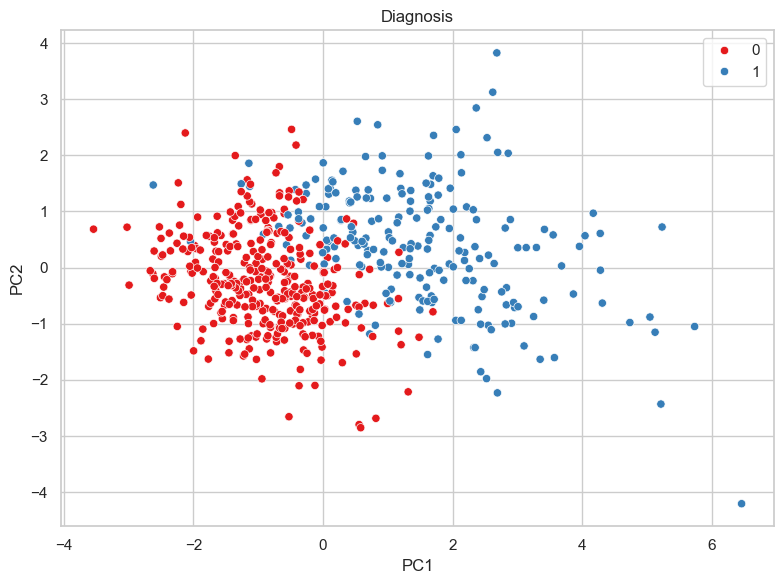

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.set(style="whitegrid")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=labels_kmn,
                palette='Set1',
                ax=axes[0],
                legend='full')
axes[0].set_title('K-means (PCA)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=labels_hier,
                palette='Set1',
                ax=axes[1],
                legend='full')
axes[1].set_title('Иерархическая кластеризация (PCA)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=y_true,
    palette='Set1',
    ax=ax,
    legend='full'
)

ax.set_title('Diagnosis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()



In [ ]:
from sklearn.metrics import rand_score, pair_confusion_matrix

print("\nPair Confusion Matrix DBSCAN:")
print(pair_confusion_matrix(y_true, labels_hier))


Pair Confusion Matrix DBSCAN:
[[130564  20804]
 [ 14572 157252]]
[[114978  36390]
 [ 23790 148034]]


In [119]:
def convert_cluster_labels(pred_labels):
    """
    Преобразует метки кластеров: 1 → 0, 2 → 1
    """
    return np.array([label - 1 for label in pred_labels])

# Или еще короче:
def convert_labels_simple(pred_labels):
    return np.array(pred_labels) - 1

converted_labels = convert_cluster_labels(labels_hier)
print(f"Было: {labels_hier}")      # [1, 1, 1, 2, 2, 2]
print(f"Стало: {converted_labels}") # [0, 0, 0, 1, 1, 1]

print("\nПОСЛЕ преобразования:")
print(f"RAND: {rand_score(y_true, converted_labels):.3f}") 
print(f"Jaccard: {jaccard_score(y_true, converted_labels):.3f}")

Было: [2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 1 1 2 1 1 2 2 2 2 1 2 1 1 1 1 1 2 2 1 2 2 1 1 1 1 2 1 2 2 1 1 2 1 2 1 2 1
 1 2 1 2 2 1 1 2 2 2 1 2 1 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1
 1 1 1 1 1 1 2 2 2 1 2 2 1 1 1 2 2 1 2 1 2 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 1 2 1 1 2 2 1 1 2 1 1 1 1 1 2 1 1 2 2 2 1 1
 1 2 1 1 1 2 1 1 2 2 1 2 1 2 2 1 2 2 2 1 1 1 2 2 1 2 1 2 1 2 2 1 1 2 2 1 1
 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 2 1 2 1 1 2 1 2 1 1 1 1 1 2 1 2 2 2 1 2 2 2
 2 2 2 2 1 2 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 2 2 2 1 1
 1 1 2 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 2
 2 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 2 1 1 1 1 1 2 1 1
 2 1 2 1 1 2 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 2 1 2 

Оба метода на двумерной проекции PCA показывают практически одинаковую картину, поскольку данные действительно разделяются на две плотные группы. Различия между алгоритмами сводятся в основном к способу, которым они формируют кластеры, но итоговое разделение остаётся совпадающим.

K-means выделяет кластеры гораздо более чётко, потому что опирается на минимизацию внутрикластерных расстояний и стремится к сферической форме групп. На графике это проявляется тем, что точки аккуратно делятся на левое и правое облако вокруг своих центроидов.

Иерархическая кластеризация приходит к тому же разбиению, хотя основывается на последовательном объединении объектов. Визуально точки раскрашены почти так же, что подтверждает устойчивость истинной структуры данных: при разных подходах к кластеризации модель всё равно находит две естественные группы.

Сопоставление двух графиков показывает, что данные хорошо поддаются разделению, и оба алгоритма дают согласованное решение. Это означает, что результатам можно доверять, поскольку различия в методологии не приводят к различиям в обнаруженных кластерах.

## Заключение

Оба метода кластеризации, K-means и иерархическая, демонстрируют высокую эффективность при разбиении данных, но их сильные стороны различаются. K-means обеспечивает более компактные и хорошо разделённые кластеры, что подтверждается высокими внутренними метриками, такими как Silhouette и Calinski-Harabasz, а также низким значением Davies-Bouldin. Это делает метод удобным для выявления плотных, сферических групп объектов и быстрого получения стабильных результатов при известном числе кластеров. Иерархическая кластеризация, несмотря на немного худшие показатели внутренних метрик, лучше отражает истинную структуру данных, что подтверждается высокими значениями Rand Index и Fowlkes-Mallows. Она позволяет наглядно изучить вложенность кластеров и выявить особенности распределения объектов, включая пересекающиеся и частично размытые группы.

Анализ выделенных кластеров показывает, что для worst-признаков Breast Cancer Wisconsin оптимальное число кластеров методом K-means равно двум, что обеспечивает максимальное сочетание компактности кластеров и соответствия реальным классам. Иерархическая кластеризация также эффективно выделяет эти два кластера, демонстрируя высокую интерпретируемость и визуальную наглядность через дендрограмму.

Вывод о применимости методов заключается в том, что K-means подходит для быстрой и эффективной кластеризации с целью формирования компактных групп, а иерархическая кластеризация является предпочтительной, если важна визуализация структуры данных и выявление вложенных уровней кластеризации. Совместное использование обоих методов позволяет получить как количественные, так и качественные характеристики кластеров, обеспечивая комплексный анализ и более глубокое понимание организации данных.

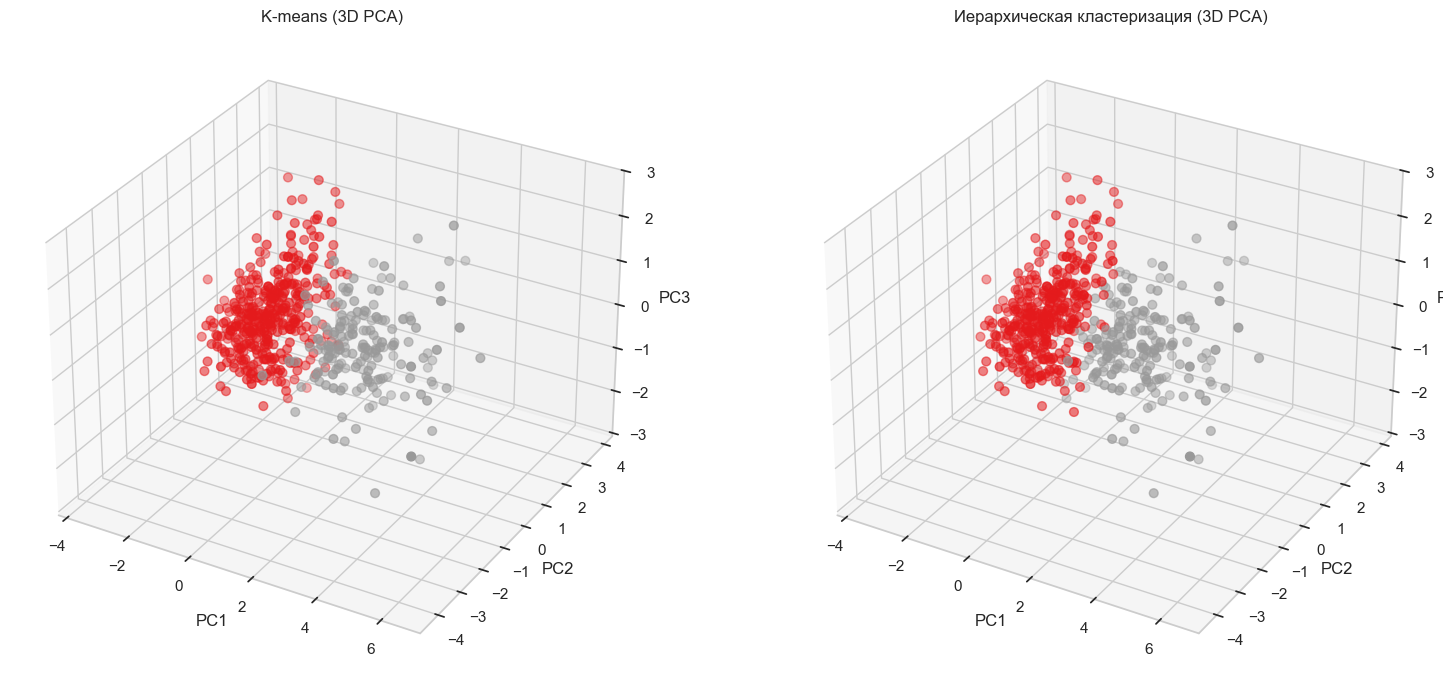

In [106]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# PCA до 3 компонент
pca_3d = PCA(n_components=3)
X_pca3 = pca_3d.fit_transform(df_scaled)

# Создаем фигуру с 2 графиками
fig = plt.figure(figsize=(16, 7))

# --- K-means ---
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2],
                       c=labels_kmn, cmap='Set1', s=40)
ax1.set_title("K-means (3D PCA)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

# --- Иерархическая кластеризация ---
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2],
                       c=labels_hier, cmap='Set1', s=40)
ax2.set_title("Иерархическая кластеризация (3D PCA)")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

plt.tight_layout()
plt.show()
